## Evaluation of UTOPIA's performance in predicting MPs size dristributionsusing the monaco Monte Carlo framework 
#### (https://monaco.readthedocs.io/en/latest/)

With this script we preform an evaluation of UTOPIA's size distribution predictive capacity by comparing predicted size distributions in targeted compartmanes aginst observed MPs size distributions reported in the compilation of published datasets by Kooi et al.

### Import the necessary libraries

In [26]:
from utopia.monte_carlo.montecarlo_analysis_paper import run_mc_analysis_paper, set_emission, sim_to_dataframe, reshape_mc_results
from utopia.monte_carlo.monte_carlo_helpers import *
from utopia.utopia import utopiaModel
import numpy as np
import scipy.stats as st
import pandas as pd

### Load the UTOPIA's default configuration parameters 

In [27]:
data_data = utopiaModel.load_json_file("data/default_data.json")
config_data = utopiaModel.load_json_file("data/default_config.json")


### Define the parameter distributions for the Monte Carlo simulation.


Transform the discrete distributions to continuous distributions for compatibility with the current montecarlo function

In [3]:
import numpy as np
# To reproduce Rakesh results, use these following discrete values to then generate distributions (lognormal and uniform) from which to sample:

# Plastic density (mpdensity): [900, 1100, 1500] kg/m³ 
# Fragmentation style (FI): [0, 0.3, 0.5, 0.7, 1.0] - ranging from more erosive to more explosive fragmentation 
# Discorporation half time (thalf_deg): [316,1000,10000, 31600, 100000] days 
# Fragmentation timescale (thalf_frag): [10, 31.6, 100, 316] days
# your discrete support values

vals_density = np.array([900, 1100, 1500])
vals_FI = np.array([0, 0.3, 0.5, 0.7, 1.0])
vals_deg = np.array([316, 1000, 10000, 31600, 100000])
vals_frag = np.array([10, 31.6, 100, 316])

def lognorm_params_from_values(values, sigma):
    """
    Return (s, scale) for scipy.stats.lognorm given target values.
    sigma = shape parameter (spread in log space).
    We center the lognormal at the geometric mean of the values.
    """
    mu = np.mean(np.log(values))  # geometric mean in log-space
    scale = np.exp(mu - (sigma**2) / 2)
    return sigma, scale

# choose sigma to control spread (tune manually!)
s_deg, scale_deg = lognorm_params_from_values(vals_deg, sigma=0.5)
s_frag, scale_frag = lognorm_params_from_values(vals_frag, sigma=0.8)
s_density, scale_density = lognorm_params_from_values(vals_density, sigma=0.1)
s_FI, scale_FI = lognorm_params_from_values(vals_FI[vals_FI > 0], sigma=0.5)  # avoid zero for lognorm

param_distributions = {
    "MPdensity_kg_m3": ("lognorm", {"s": s_density, "scale": scale_density}),
    "FI": ("uniform", {"loc": 0.0, "scale": 1.0}),
    "t_half_deg_free": ("lognorm", {"s": s_deg, "scale": scale_deg}),
    "t_frag_gen_FreeSurfaceWater": ("lognorm", {"s": s_frag, "scale": scale_frag})
}



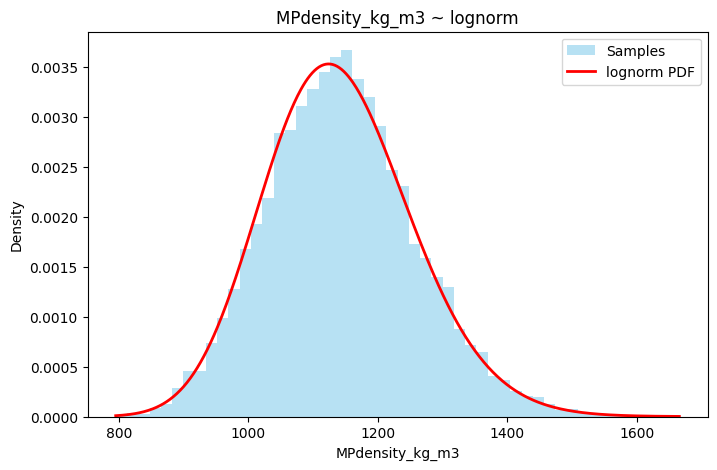

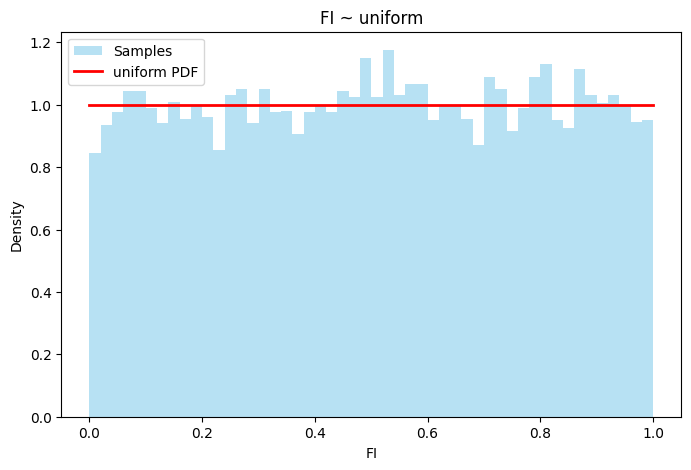

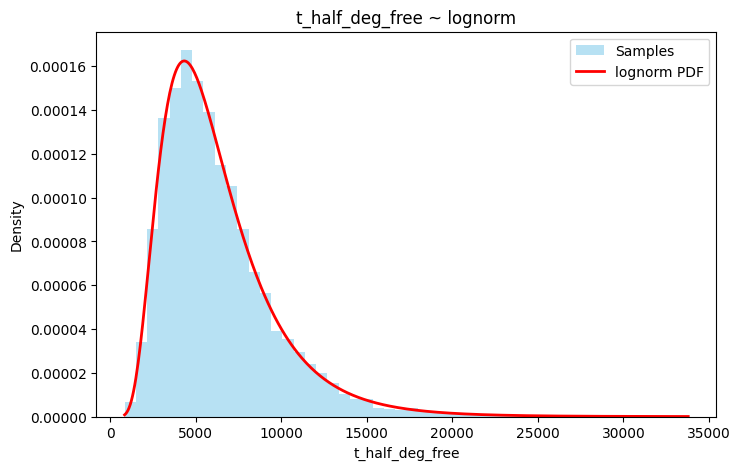

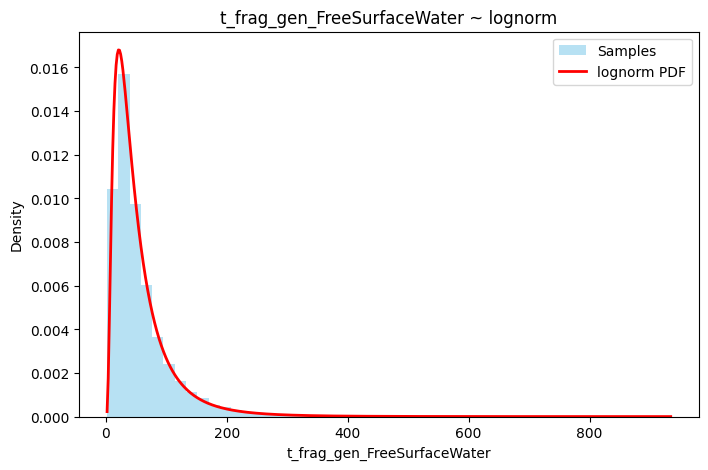

In [4]:
# Visualise the distributions by plotting

for psrsm in param_distributions:
    plot_distribution_from_dict(psrsm, param_distributions)

In [6]:

# Recent studies have challenged the density of biofilm used here (1388 kg m-3) as being too high. see e.g. # https://doi.org/10.1186/s43591-024-00098-2 
# Consider testing chnages in biofouling density

In [5]:
# Set emission scenarios to run that are compatible for comparison with observations data from Kooi et al.

##############################################
# DEFINE ARTICLE -> EMISSION SCENARIOS
##############################################

overlay_emission_scenarios = {
    "Sea Sediment | Bergmann":["Ocean_Surface_Water","Coast_Surface_Water","Coast_Column_Water"],
    "Sea Surface all | Cai":["Surface_Freshwater","Coast_Surface_Water","Impacted_Soil_Surface"],
    "Sea Surface Fragments | Enders":["Ocean_Surface_Water","Coast_Surface_Water"],
    "Sea Surface Fibers | Enders":["Ocean_Surface_Water","Coast_Surface_Water"],
    "Fragments in water | Eo":["Impacted_Soil_Surface","Surface_Freshwater"],
    "Fibers in water | Eo":["Impacted_Soil_Surface","Surface_Freshwater"],
    "Fragments in sediment | Eo":["Impacted_Soil_Surface","Surface_Freshwater"],
    "Fibers in sediment | Eo":["Impacted_Soil_Surface","Surface_Freshwater"],
    "Sea Surface all | Erni-Cassola":["Coast_Surface_Water","Impacted_Soil_Surface"],
    "Fresh water sediments | Imhof":["Surface_Freshwater","Impacted_Soil_Surface"],
    "Sea Surface all | Isobe L1":["Surface_Freshwater","Coast_Surface_Water"],
    "Sea Surface all | Isobe L2":["Surface_Freshwater","Coast_Surface_Water"],
    "Sea Surface all | Isobe L3":["Surface_Freshwater","Coast_Surface_Water"],
    "Sea Surface all | Isobe L4":["Surface_Freshwater","Coast_Surface_Water"],
    "FP all | Scheurer":["Impacted_Soil_Surface"],
    "Sea Surface Fragments | Song":["Impacted_Soil_Surface","Surface_Freshwater"],
    "Sea Surface Fibers | Song":["Impacted_Soil_Surface","Surface_Freshwater"],
    "Sea Surface all | Zhang":["Coast_Surface_Water","Surface_Freshwater"]}
    
    
    
    
# DEFINE ARTICLE->COMPARTMENTS MAPPING
#############################################
overlay_compartments_mapping = {
    "Sea Sediment | Bergmann": ["Sediment_Coast", "Sediment_Ocean"],
    "Sea Surface all | Cai": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "Sea Surface Fragments | Enders": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "Sea Surface Fibers | Enders": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "Fragments in water | Eo": ["Bulk_Freshwater", "Surface_Freshwater"],
    "Fibers in water | Eo": ["Bulk_Freshwater", "Surface_Freshwater"],
    "Fragments in sediment | Eo": ["Sediment_Ocean", "Sediment_Coast", "Beaches_Deep_Soil","Beaches_Soil_Surface", "Sediment_Freshwater"],
    "Fibers in sediment | Eo": ["Sediment_Ocean", "Sediment_Coast", "Beaches_Deep_Soil",
    "Beaches_Soil_Surface", "Sediment_Freshwater"],
    "Sea Surface all | Erni-Cassola": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "Fresh water sediments | Imhof": ["Bulk_Freshwater", "Surface_Freshwater"],
    "Sea Surface all | Isobe L1": ["Coast_Surface_Water", "Ocean_Surface_Water"], 
    "Sea Surface all | Isobe L2": ["Coast_Surface_Water", "Ocean_Surface_Water"], 
    "Sea Surface all | Isobe L3": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "Sea Surface all | Isobe L4": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "FP all | Scheurer": ["Coast_Surface_Water", "Ocean_Surface_Water"], 
    "Sea Surface Fragments | Song": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "Sea Surface Fibers | Song": ["Coast_Surface_Water", "Ocean_Surface_Water"],
    "Sea Surface all | Zhang": ["Coast_Surface_Water", "Ocean_Surface_Water"]
}

# NOTE! Maybe the mapping for the FP all | Scheurer study has to be revisited. Samples were collected in floodplain soils, so the impacted_soil_surface compartment might be more appropriate. Since the model does not simulate floodplain soils as a separate compartment.?

In [8]:
# Set emission scenarios according to the mapping defined above to the run the model for each parameter combination using the Monte Carlo framework and perform the comparison with the observed data according to mapping.

Test difference in results if run with distributions or single values for the parameters for one article

Running Monte Carlo analysis for article: Sea Sediment | Bergmann
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done


Running cases:  30%|███       | 6/20 [00:13<00:31,  2.22s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  45%|████▌     | 9/20 [00:19<00:23,  2.18s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 1392.18 cases/s]

Simulation complete! Runtime: 0:00:44.245699
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Running cases:  30%|███       | 6/20 [00:13<00:31,  2.22s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  45%|████▌     | 9/20 [00:19<00:24,  2.25s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 12685.03 cases/s]

Simulation complete! Runtime: 0:00:45.289060
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Running cases:  30%|███       | 6/20 [00:13<00:31,  2.28s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  45%|████▌     | 9/20 [00:20<00:25,  2.28s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 20/20 [00:00<?, ? cases/s]

Simulation complete! Runtime: 0:00:47.558976
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Running cases:  30%|███       | 6/20 [00:17<00:41,  2.98s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  45%|████▌     | 9/20 [00:25<00:31,  2.86s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 20/20 [00:00<?, ? cases/s]

Simulation complete! Runtime: 0:00:49.858126
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Running cases:  30%|███       | 6/20 [00:13<00:31,  2.22s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  45%|████▌     | 9/20 [00:19<00:24,  2.19s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 1077.66 cases/s]

Simulation complete! Runtime: 0:00:45.182995
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Running cases:  30%|███       | 6/20 [00:13<00:32,  2.31s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  45%|████▌     | 9/20 [00:20<00:24,  2.26s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 6668.74 cases/s]

Simulation complete! Runtime: 0:00:44.840277


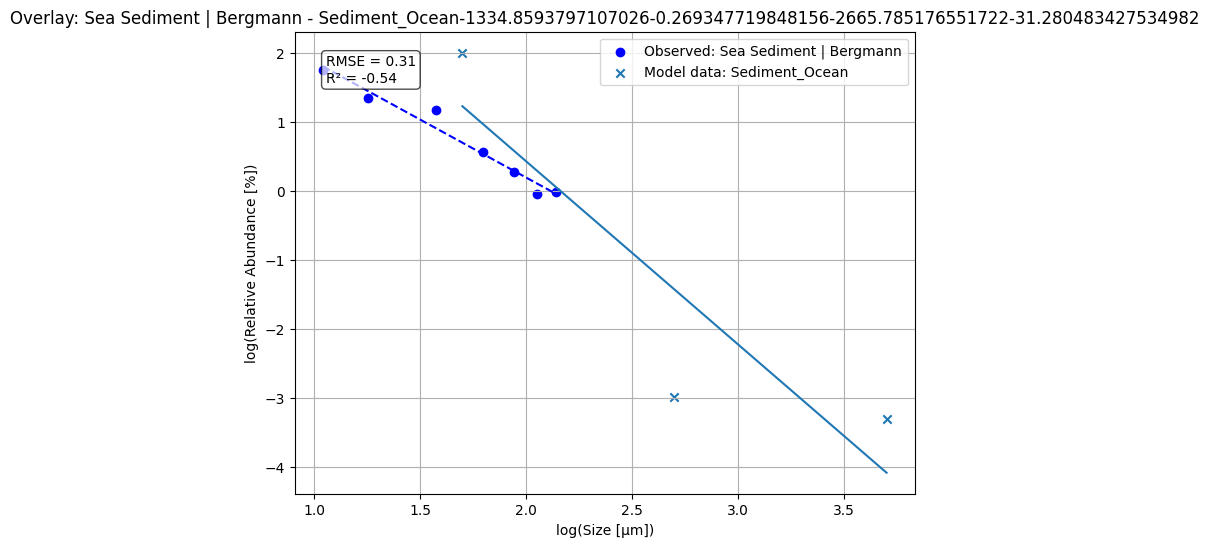

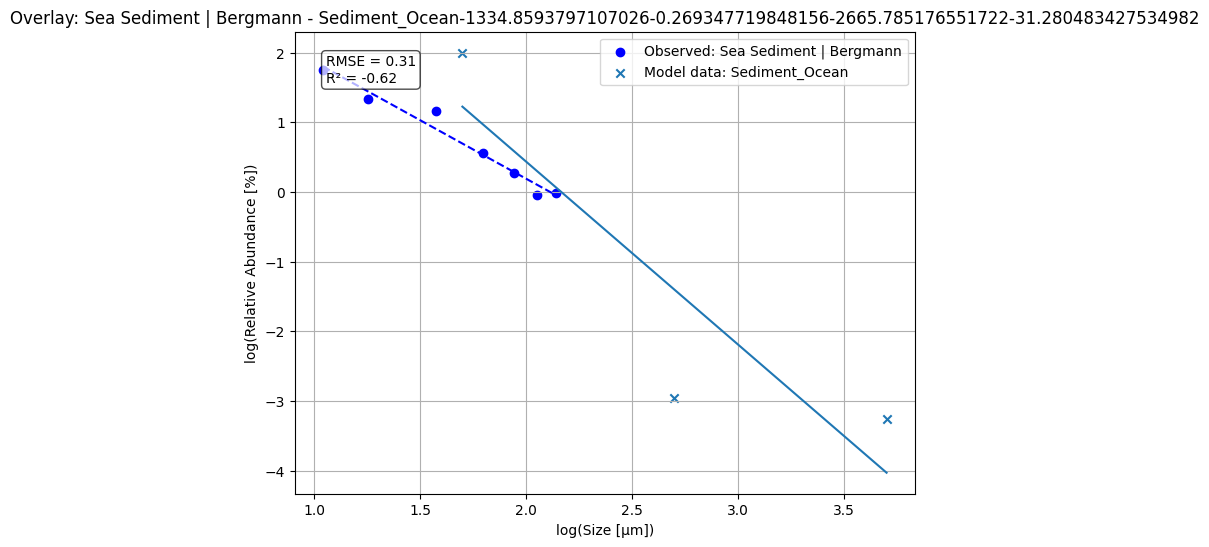

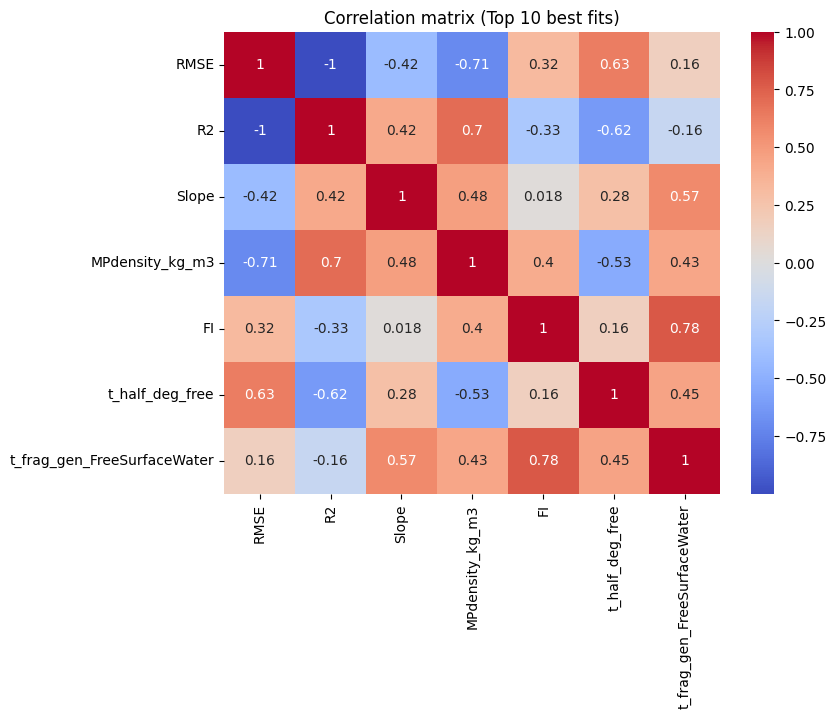

Running Monte Carlo analysis for article: Sea Surface all | Cai
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done


Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 1947.80 cases/s]

Simulation complete! Runtime: 0:00:42.238549
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 9901.57 cases/s]

Simulation complete! Runtime: 0:00:45.051758
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 9242.63 cases/s]

Simulation complete! Runtime: 0:00:44.764295
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 2693.75 cases/s]

Simulation complete! Runtime: 0:00:51.060956
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<?, ? cases/s]

Simulation complete! Runtime: 0:00:44.967977
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 4784.47 cases/s]

Simulation complete! Runtime: 0:00:44.267757


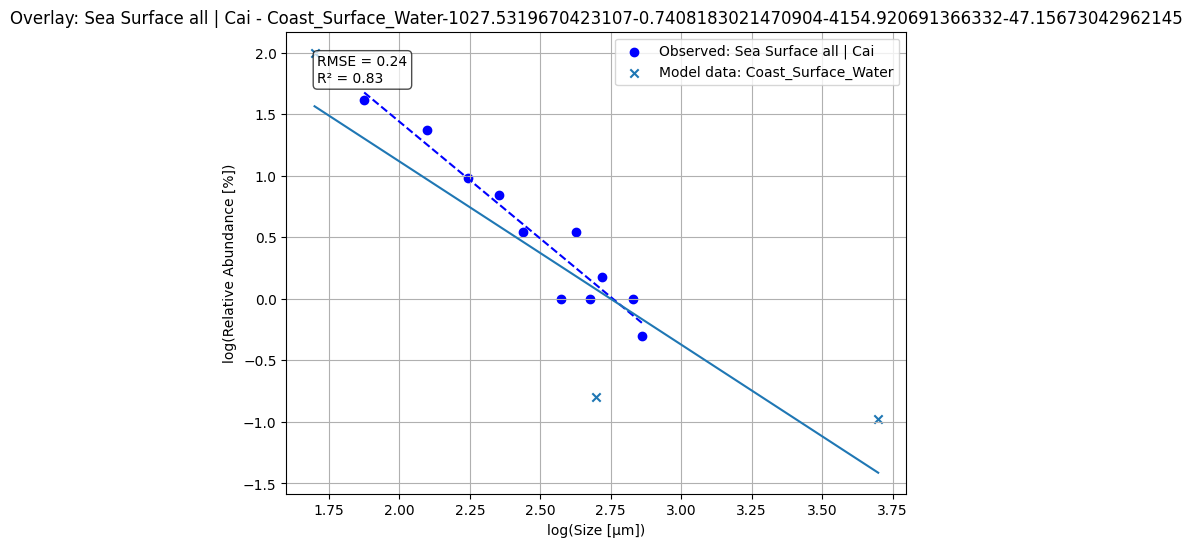

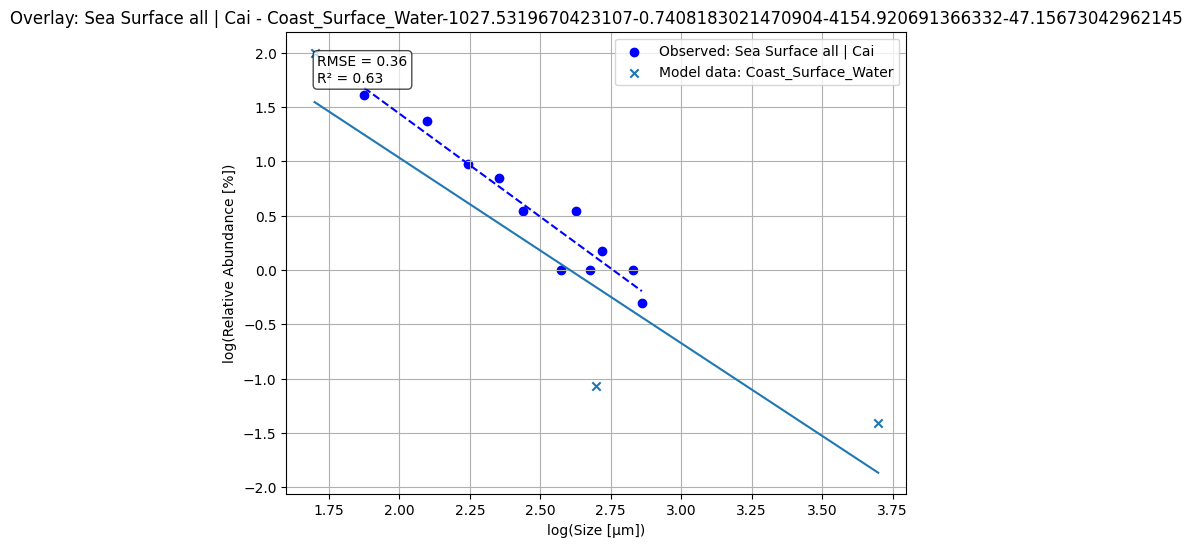

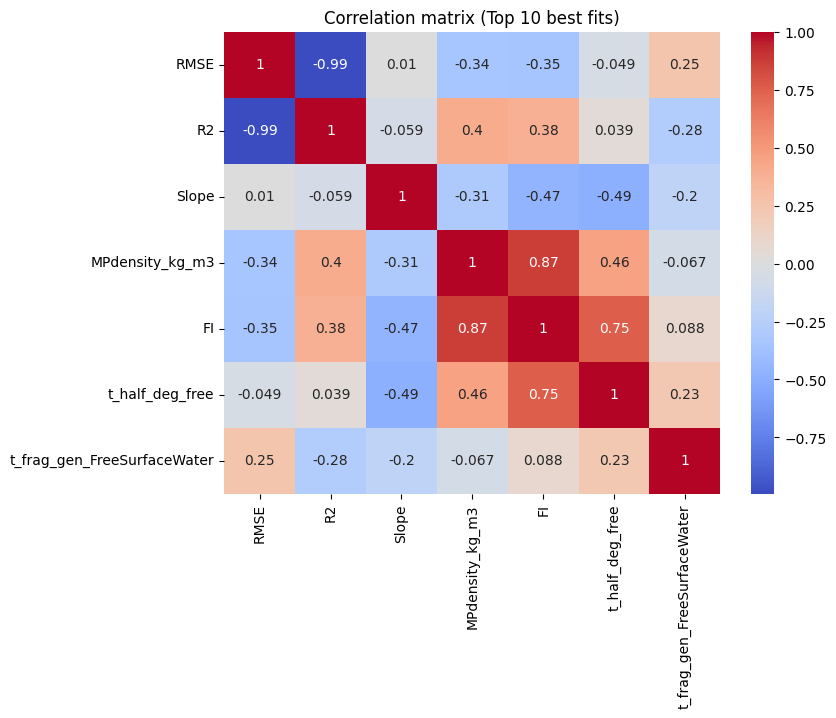

Running Monte Carlo analysis for article: Sea Surface Fragments | Enders
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done


Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 6674.58 cases/s]

Simulation complete! Runtime: 0:00:44.948699
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 3999.15 cases/s]

Simulation complete! Runtime: 0:00:44.217969
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 6670.86 cases/s] 

Simulation complete! Runtime: 0:00:43.174186
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<?, ? cases/s]

Simulation complete! Runtime: 0:00:46.206926


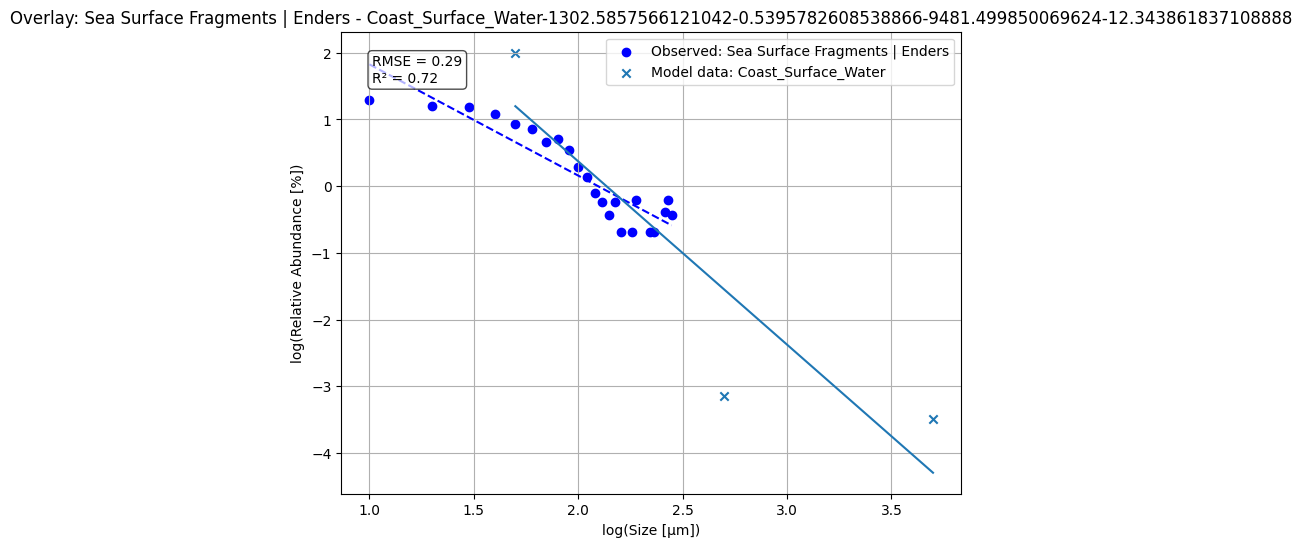

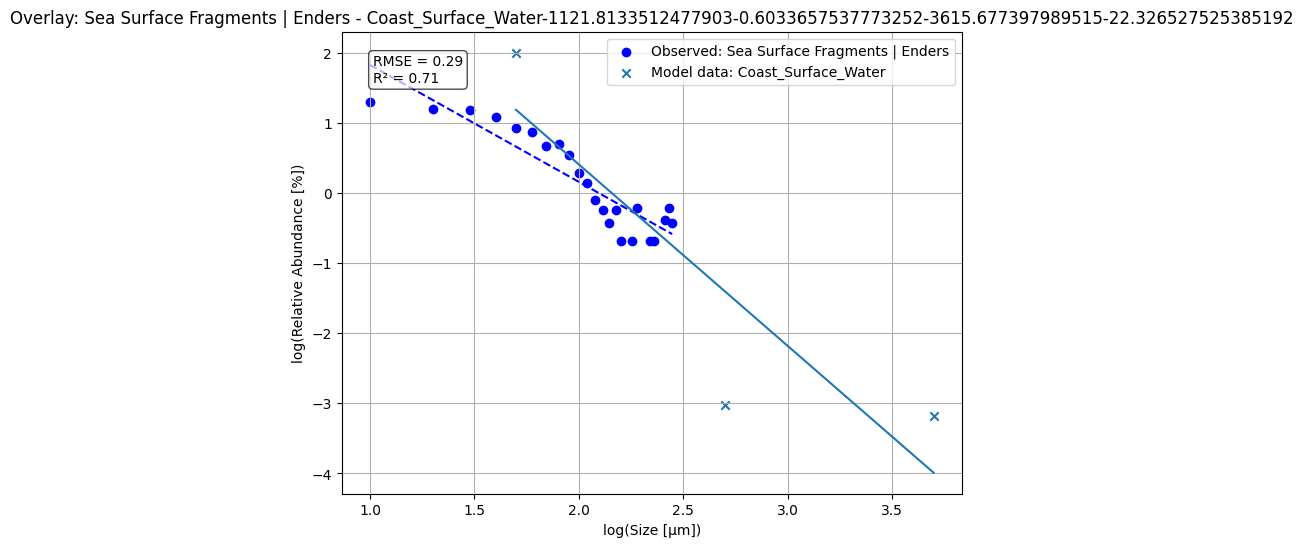

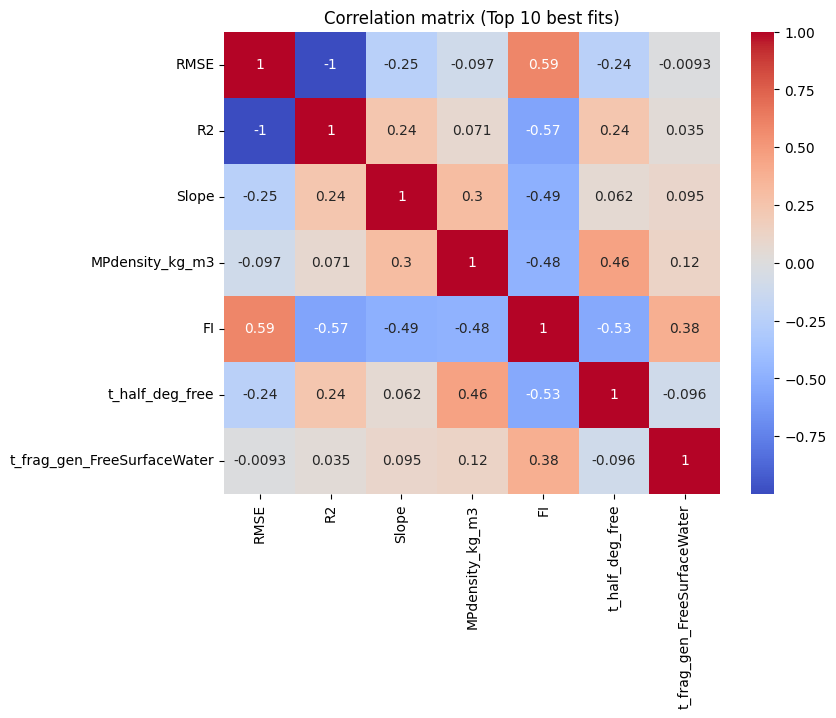

Running Monte Carlo analysis for article: Sea Surface Fibers | Enders
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done


Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 6657.63 cases/s]

Simulation complete! Runtime: 0:00:47.661705
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 9993.58 cases/s] 

Simulation complete! Runtime: 0:00:46.174537
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 4007.55 cases/s]

Simulation complete! Runtime: 0:00:44.081222
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 6668.74 cases/s] 

Simulation complete! Runtime: 0:00:46.917953


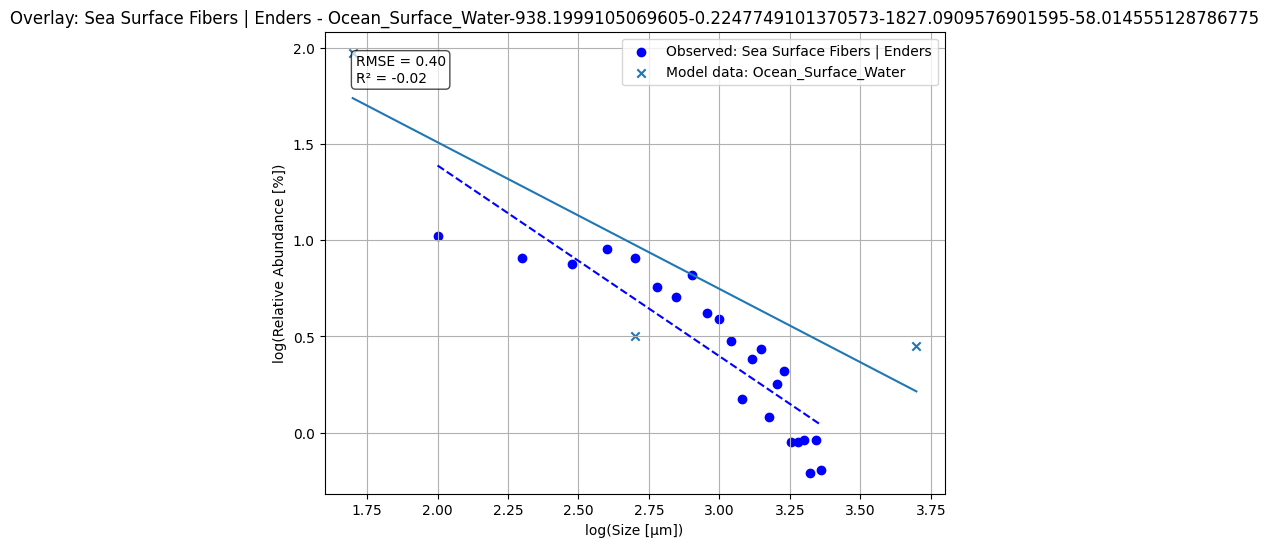

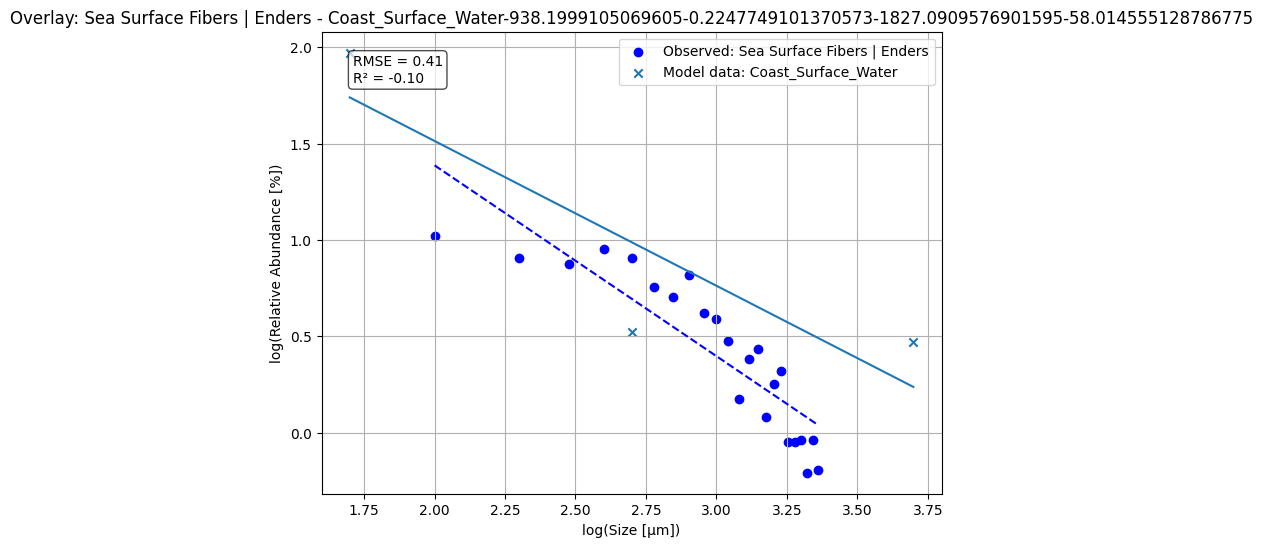

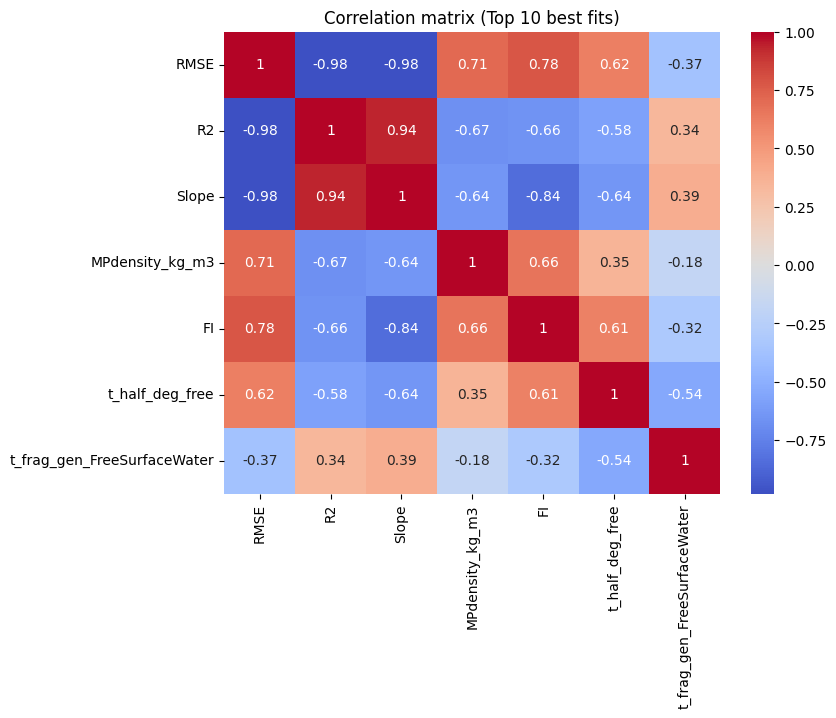

Running Monte Carlo analysis for article: Fragments in water | Eo
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done


Postprocessing cases: 100%|██████████| 20/20 [00:00<?, ? cases/s]

Simulation complete! Runtime: 0:00:46.137728
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 10013.86 cases/s]

Simulation complete! Runtime: 0:00:45.828772
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 39327.74 cases/s]

Simulation complete! Runtime: 0:00:52.381723
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 6104.80 cases/s]

Simulation complete! Runtime: 0:00:45.139123


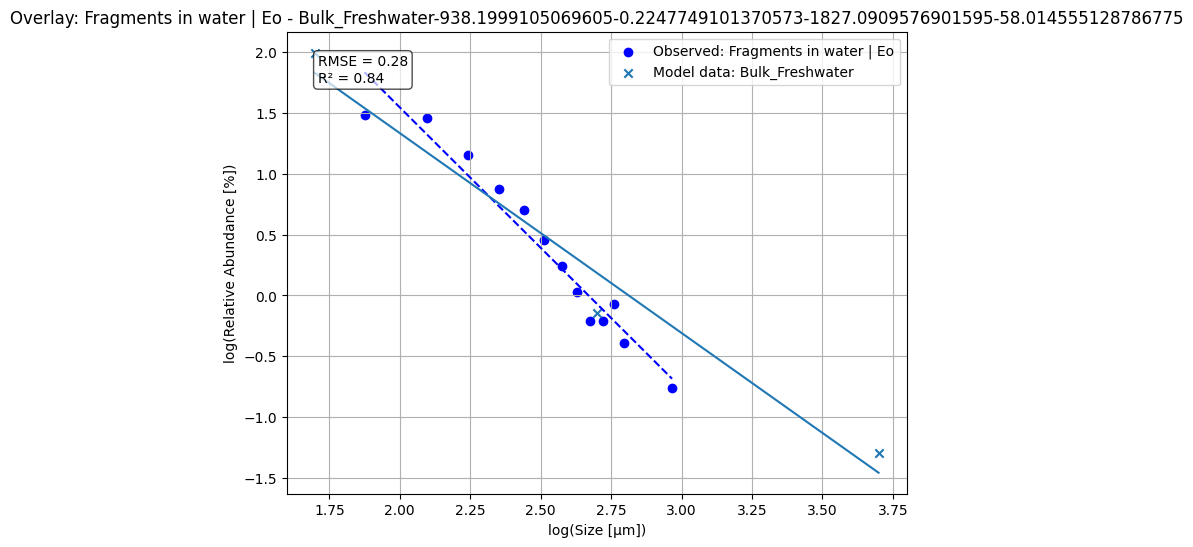

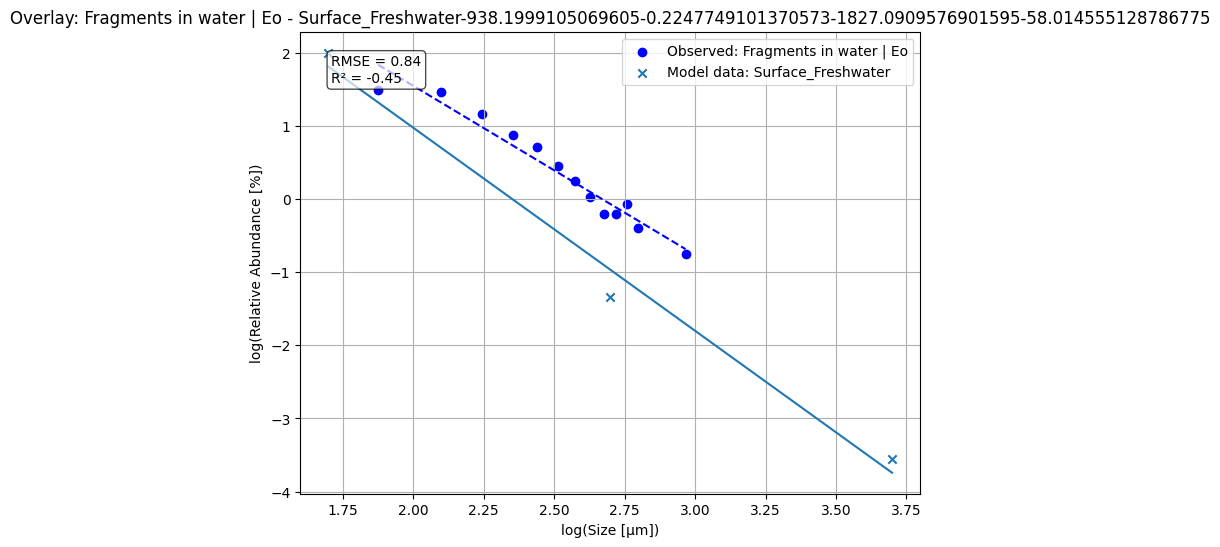

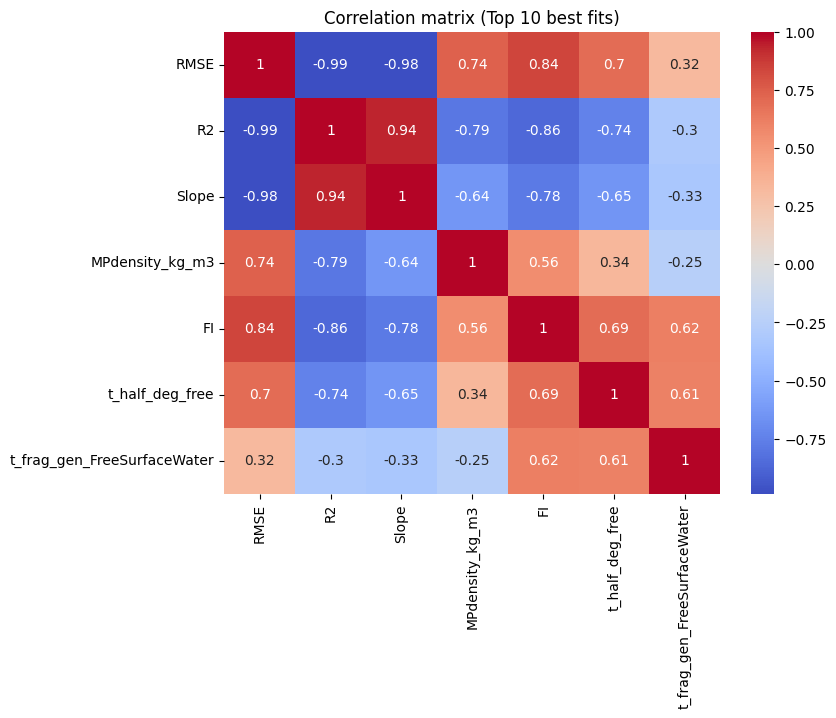

Running Monte Carlo analysis for article: Fibers in water | Eo
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done


Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 4001.24 cases/s]

Simulation complete! Runtime: 0:00:45.215207
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 1598.29 cases/s]

Simulation complete! Runtime: 0:00:44.992788
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 13070.44 cases/s]

Simulation complete! Runtime: 0:00:44.959924
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<?, ? cases/s]

Simulation complete! Runtime: 0:00:44.762071


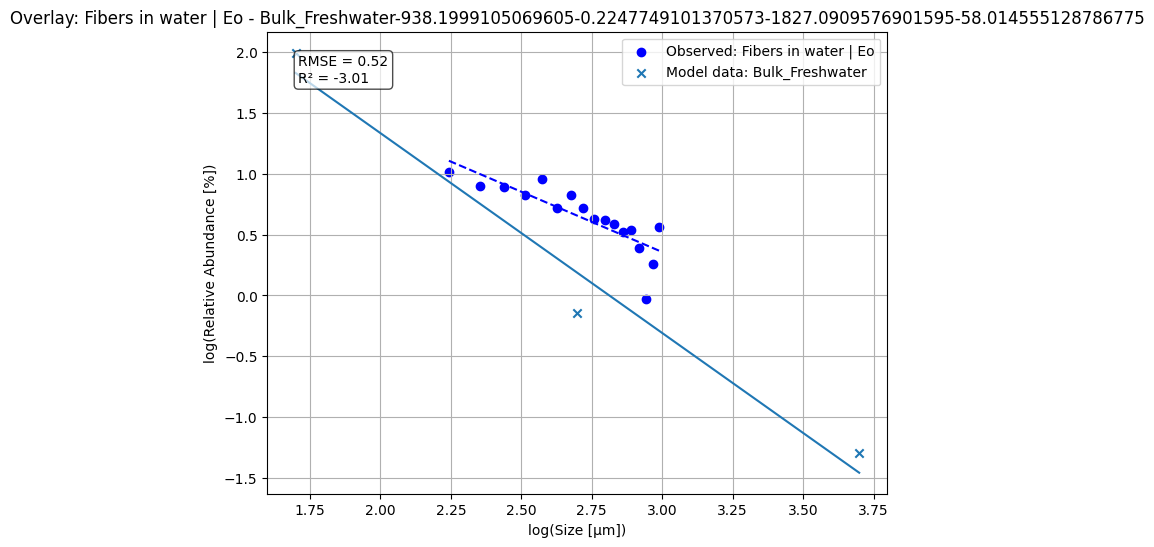

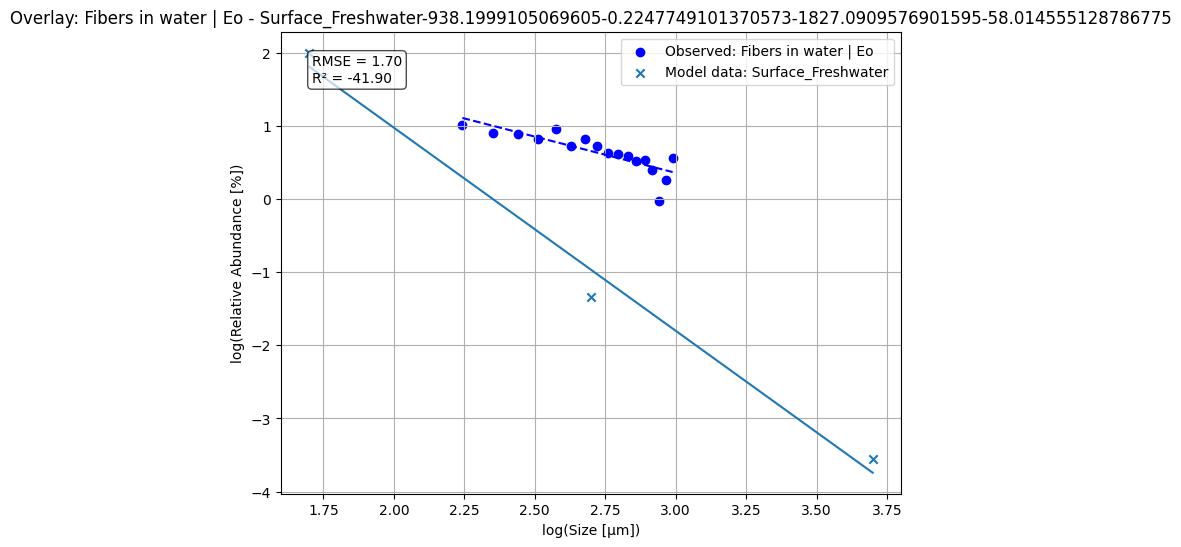

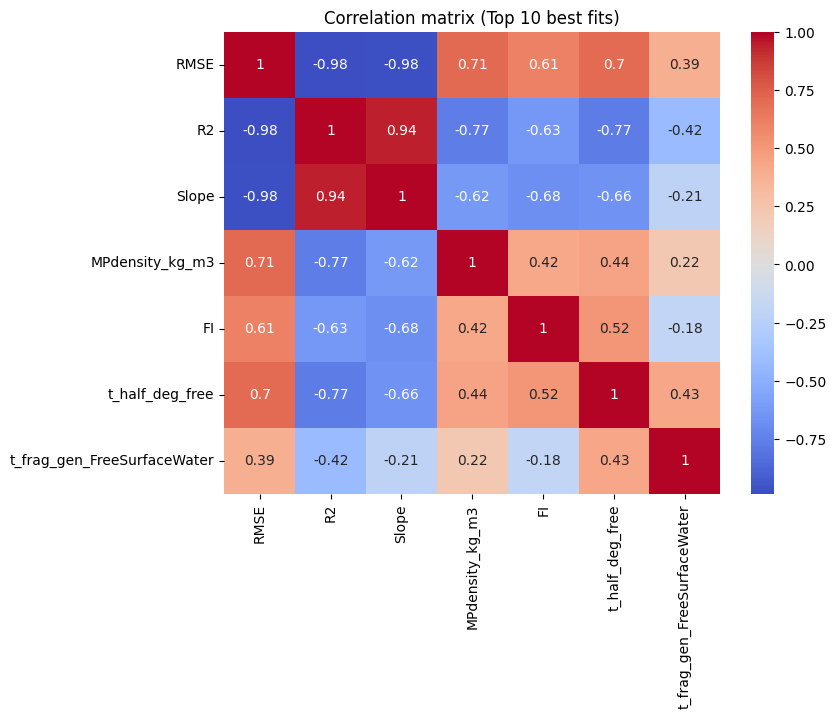

Running Monte Carlo analysis for article: Fragments in sediment | Eo
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done


Running cases:  30%|███       | 6/20 [00:14<00:34,  2.43s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  45%|████▌     | 9/20 [00:22<00:29,  2.67s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 11375.93 cases/s]

Simulation complete! Runtime: 0:00:52.047805
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Running cases:  30%|███       | 6/20 [00:14<00:32,  2.35s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  45%|████▌     | 9/20 [00:20<00:25,  2.30s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 14485.59 cases/s]

Simulation complete! Runtime: 0:00:45.901606
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<?, ? cases/s]

Simulation complete! Runtime: 0:00:46.397849
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 7117.43 cases/s]

Simulation complete! Runtime: 0:00:45.979453
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Running cases:  30%|███       | 6/20 [00:14<00:33,  2.39s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 6614.58 cases/s]

Simulation complete! Runtime: 0:00:46.904220
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Running cases:  30%|███       | 6/20 [00:15<00:36,  2.64s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  45%|████▌     | 9/20 [00:22<00:27,  2.46s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 20/20 [00:00<?, ? cases/s]

Simulation complete! Runtime: 0:00:47.860138
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Running cases:  30%|███       | 6/20 [00:13<00:32,  2.33s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  45%|████▌     | 9/20 [00:20<00:25,  2.29s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 1582.82 cases/s]

Simulation complete! Runtime: 0:00:49.178463
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 32263.88 cases/s]

Simulation complete! Runtime: 0:00:47.409701
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<?, ? cases/s]

Simulation complete! Runtime: 0:00:44.681698
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Running cases:  30%|███       | 6/20 [00:13<00:30,  2.19s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 20/20 [00:00<?, ? cases/s]

Simulation complete! Runtime: 0:00:44.238999


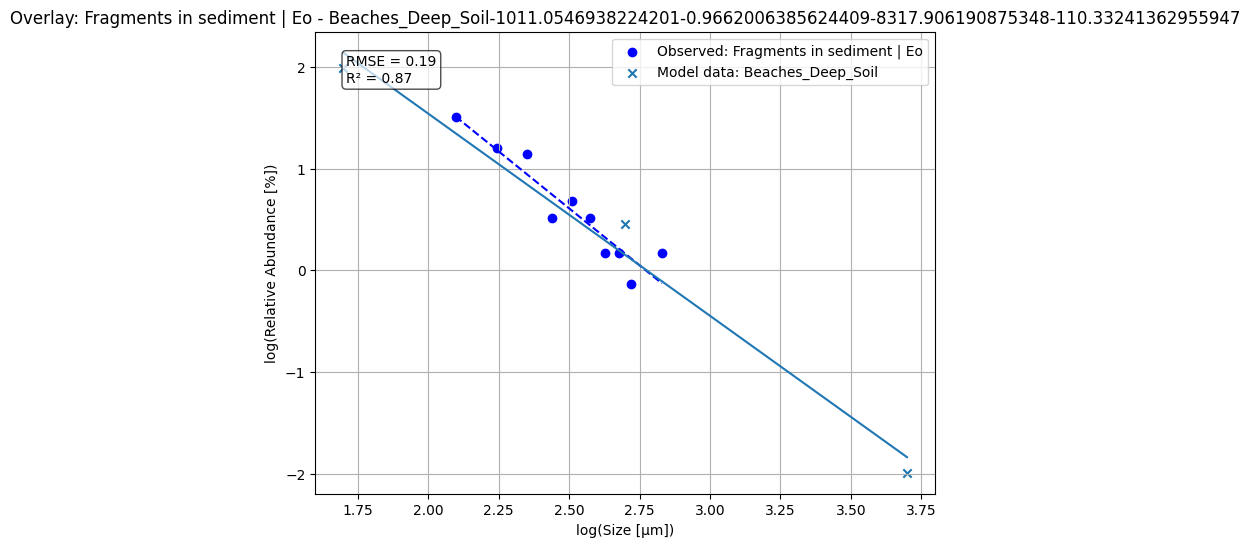

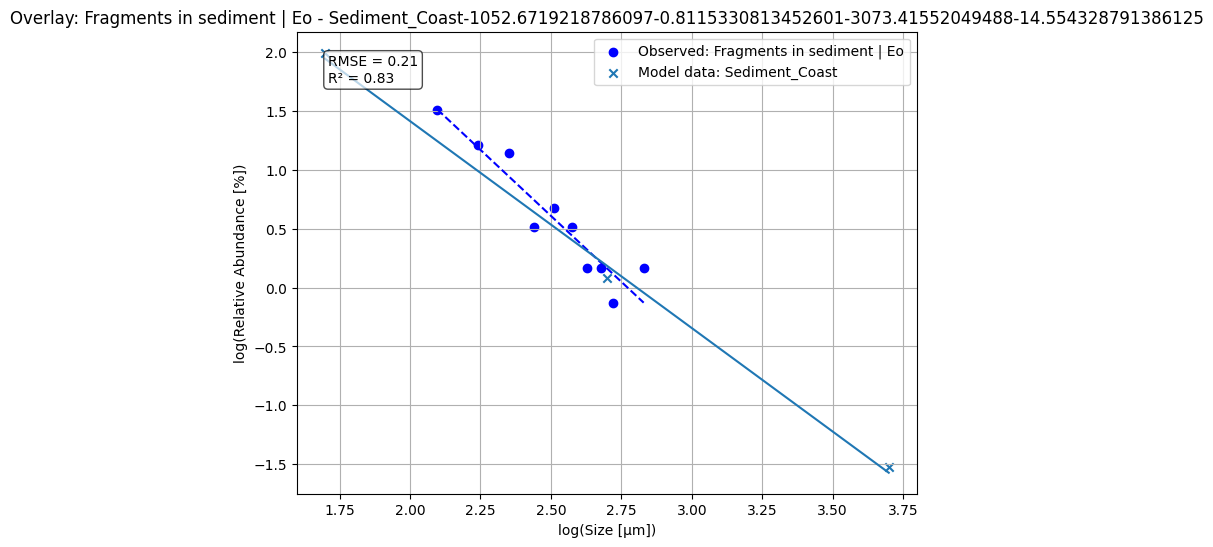

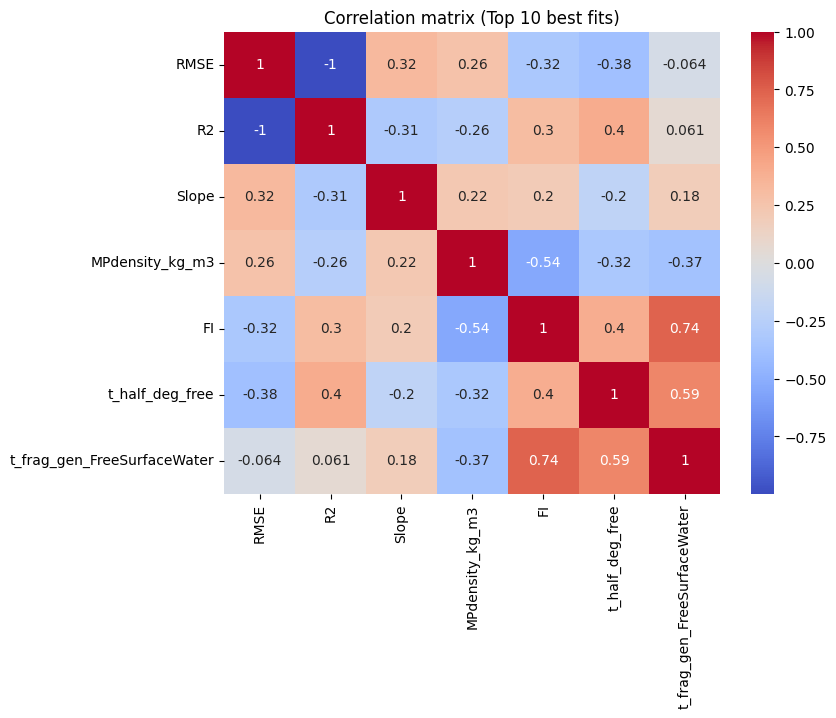

Running Monte Carlo analysis for article: Fibers in sediment | Eo
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done


Running cases:  30%|███       | 6/20 [00:13<00:31,  2.28s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  45%|████▌     | 9/20 [00:20<00:25,  2.30s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 7303.97 cases/s] 

Simulation complete! Runtime: 0:00:46.633080
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Running cases:  30%|███       | 6/20 [00:12<00:30,  2.16s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  45%|████▌     | 9/20 [00:19<00:23,  2.15s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 9988.82 cases/s]

Simulation complete! Runtime: 0:00:42.644580
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 4166.18 cases/s]

Simulation complete! Runtime: 0:00:52.209533
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<?, ? cases/s]

Simulation complete! Runtime: 0:01:03.323625
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Running cases:  30%|███       | 6/20 [00:16<00:37,  2.69s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 1583.71 cases/s]

Simulation complete! Runtime: 0:00:53.695313
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Running cases:  30%|███       | 6/20 [00:15<00:35,  2.53s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  45%|████▌     | 9/20 [00:22<00:27,  2.51s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 7212.90 cases/s] 

Simulation complete! Runtime: 0:00:50.233381
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Running cases:  30%|███       | 6/20 [00:16<00:40,  2.86s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Running cases:  45%|████▌     | 9/20 [00:25<00:31,  2.88s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 38728.57 cases/s]

Simulation complete! Runtime: 0:00:56.184377
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<?, ? cases/s]

Simulation complete! Runtime: 0:00:56.435091
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<?, ? cases/s]

Simulation complete! Runtime: 0:01:02.851453
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Running cases:  30%|███       | 6/20 [00:15<00:37,  2.65s/ cases]c:\Users\PradoDomercq\AppData\Local\miniconda3\envs\utopia_envP11\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 5545.45 cases/s] 

Simulation complete! Runtime: 0:00:49.496846


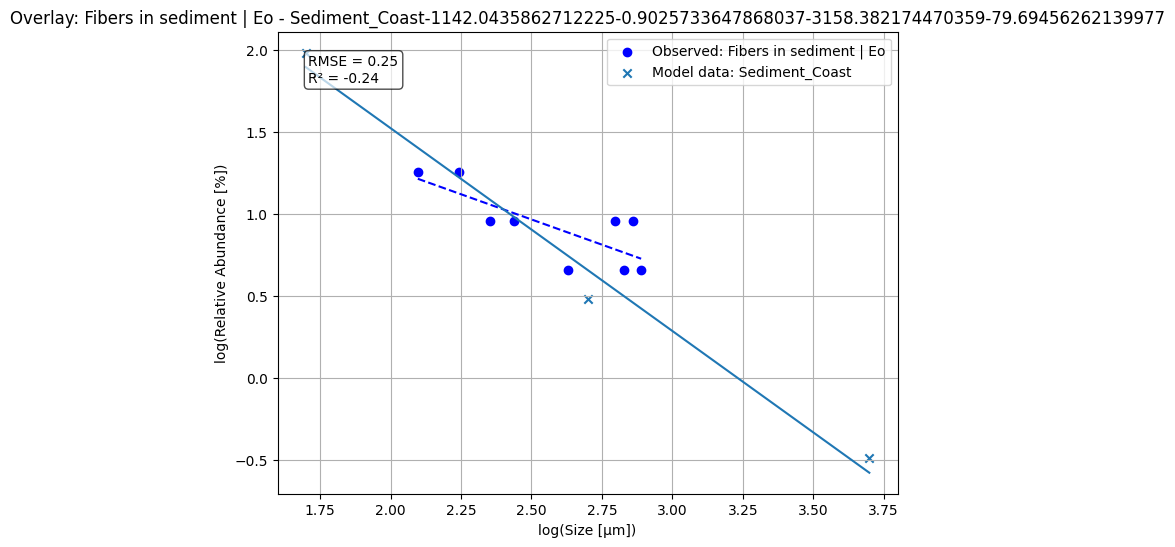

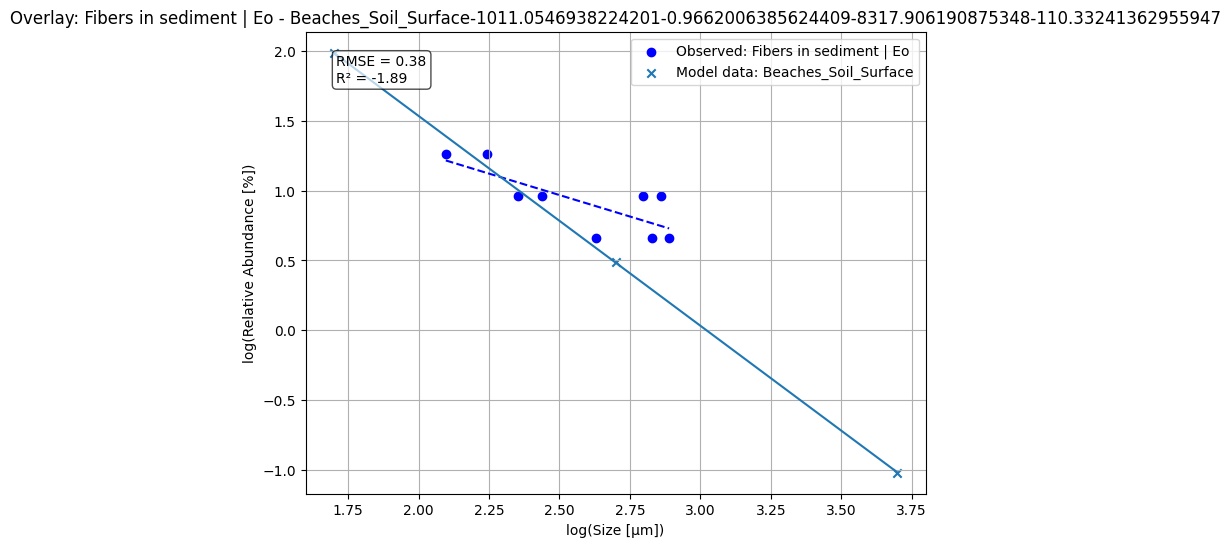

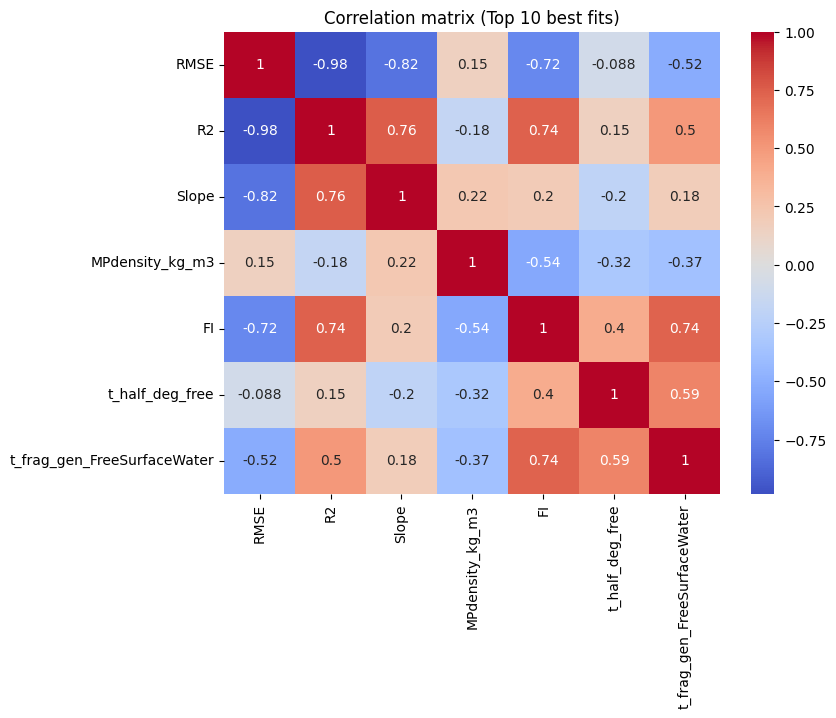

Running Monte Carlo analysis for article: Sea Surface all | Erni-Cassola
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done


Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 6669.27 cases/s]

Simulation complete! Runtime: 0:00:44.277251
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 3020.96 cases/s]

Simulation complete! Runtime: 0:00:42.969148
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 4907.63 cases/s]

Simulation complete! Runtime: 0:00:43.967600
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 6679.36 cases/s]

Simulation complete! Runtime: 0:00:42.139883


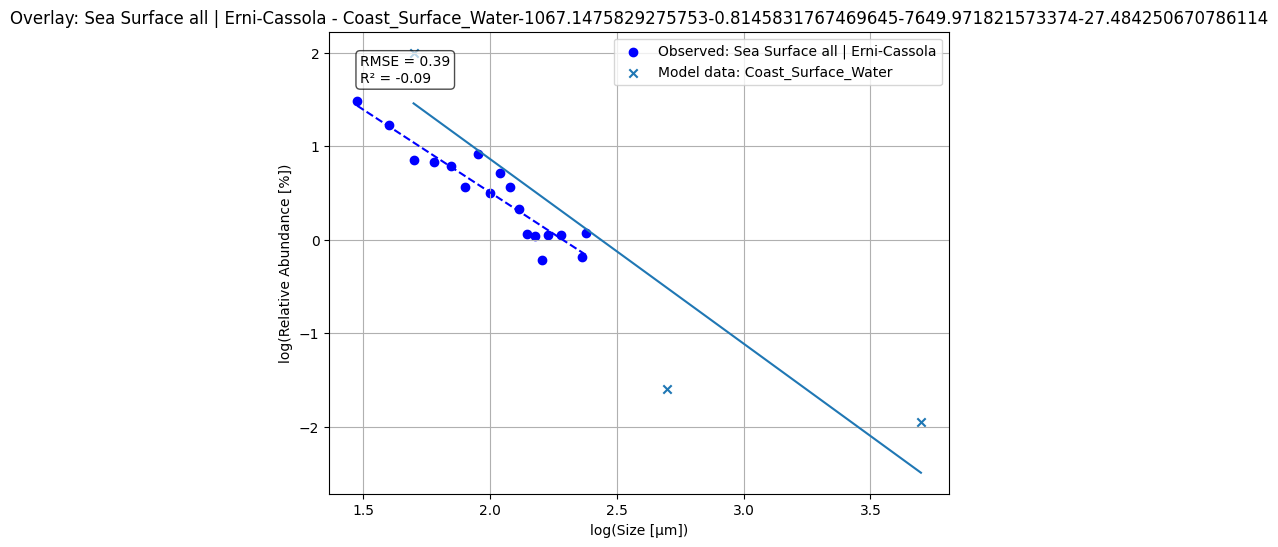

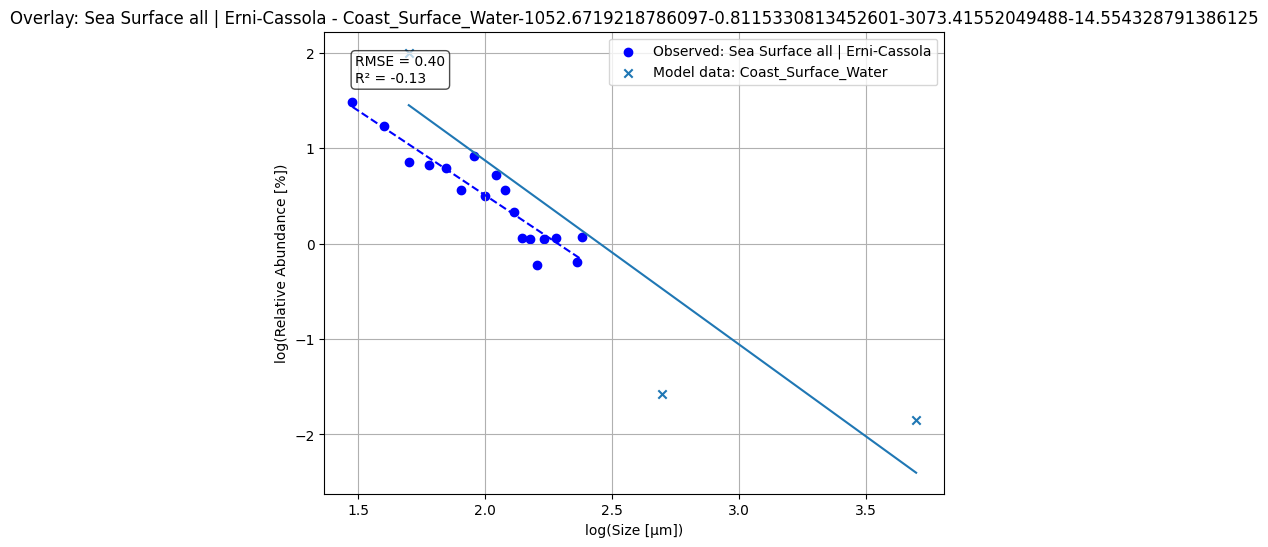

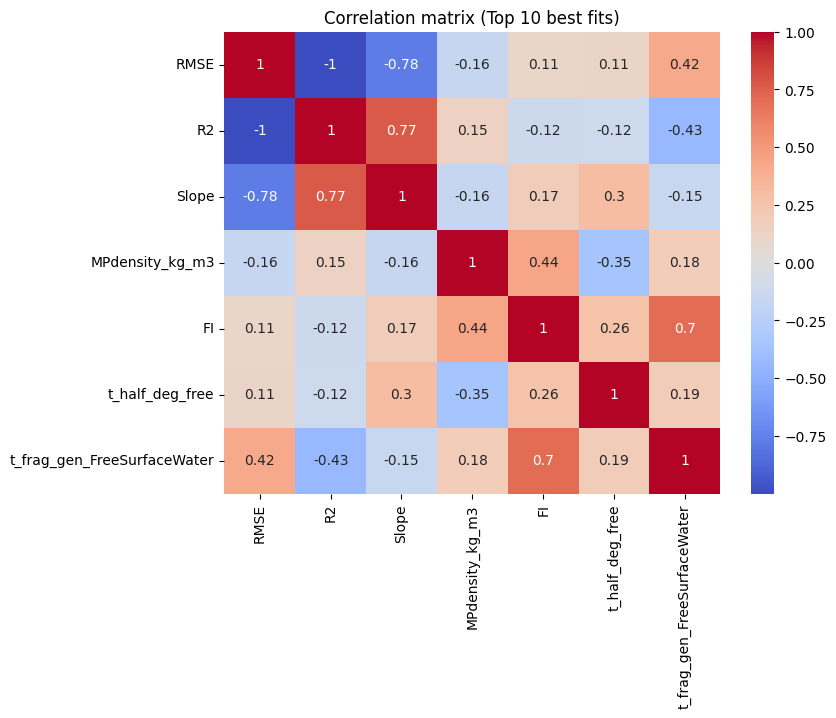

Running Monte Carlo analysis for article: Fresh water sediments | Imhof
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done


Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 2097.78 cases/s]

Simulation complete! Runtime: 0:00:48.725166
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 7401.93 cases/s] 

Simulation complete! Runtime: 0:00:44.209355
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<?, ? cases/s]

Simulation complete! Runtime: 0:00:42.402581
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<?, ? cases/s]

Simulation complete! Runtime: 0:00:41.859443


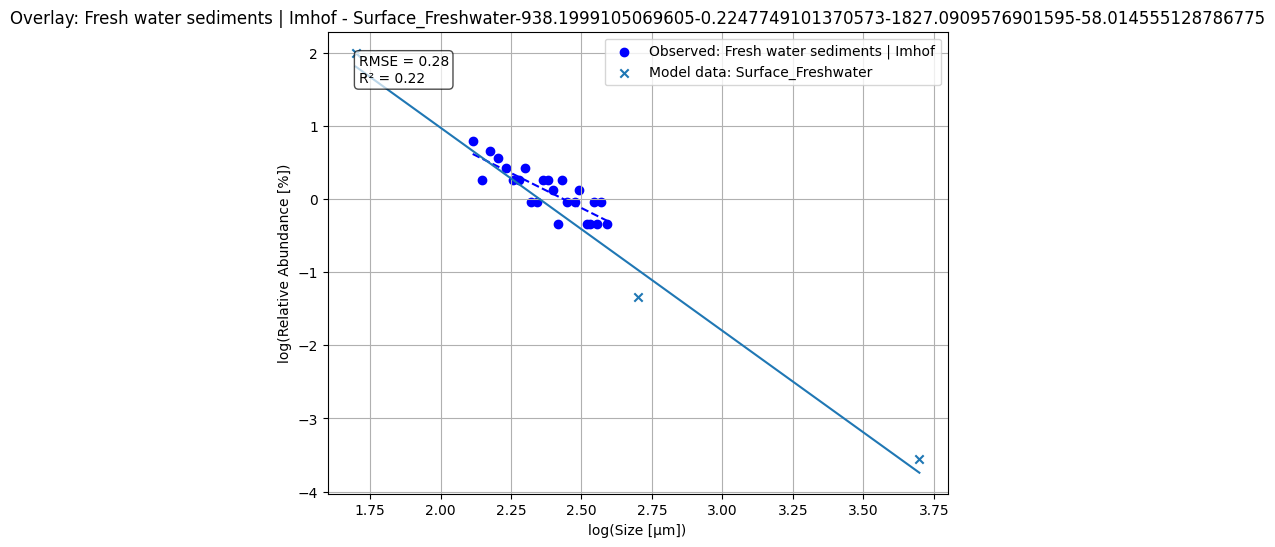

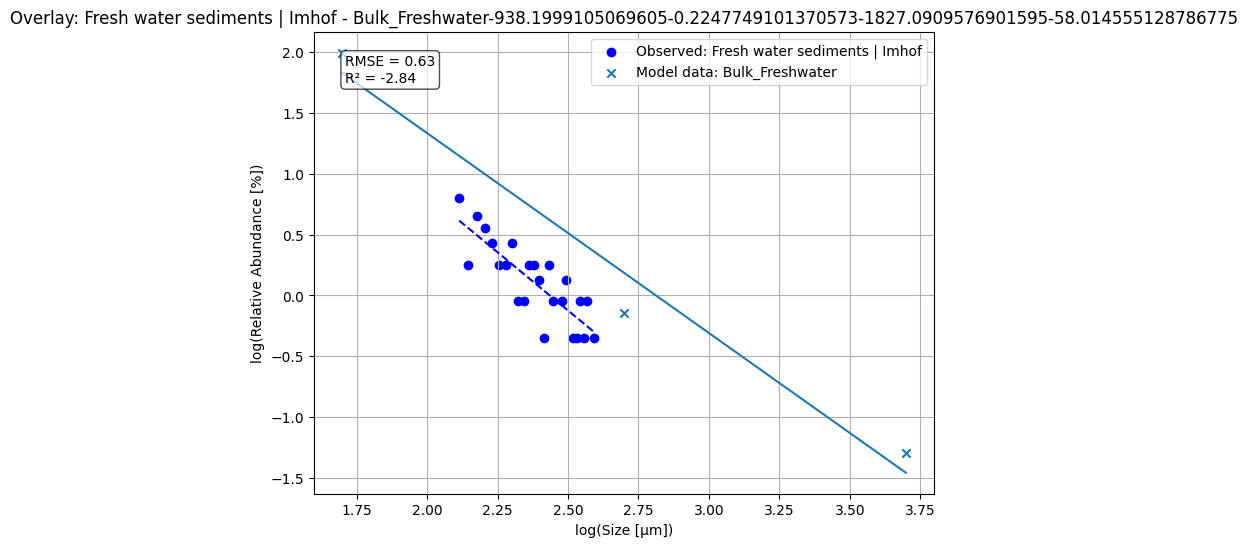

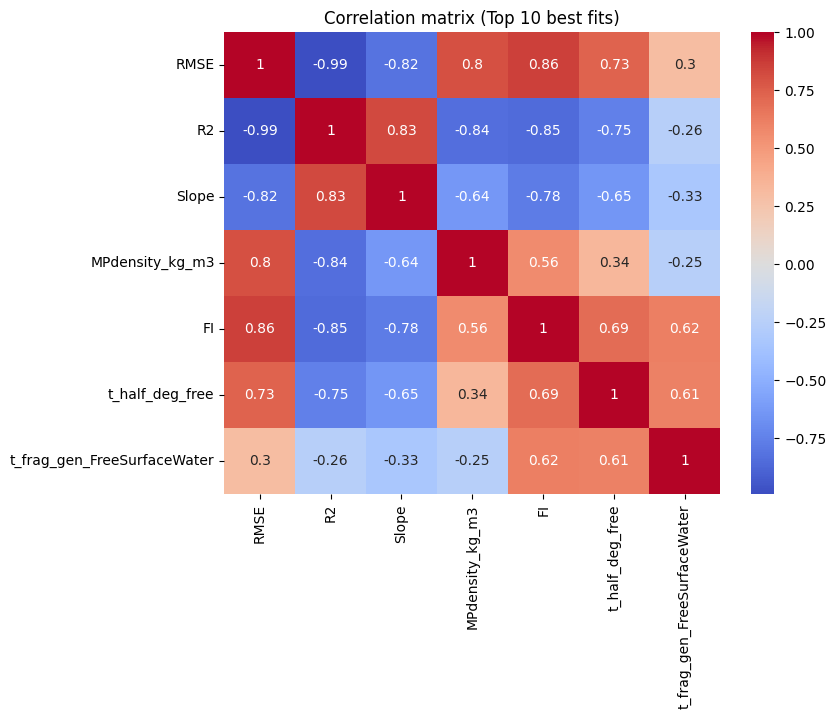

Running Monte Carlo analysis for article: Sea Surface all | Isobe L1
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done


Postprocessing cases: 100%|██████████| 20/20 [00:00<?, ? cases/s]

Simulation complete! Runtime: 0:00:41.621264
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<?, ? cases/s]

Simulation complete! Runtime: 0:00:42.517210
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 19977.63 cases/s]

Simulation complete! Runtime: 0:00:42.602988
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<?, ? cases/s]

Simulation complete! Runtime: 0:00:50.363174


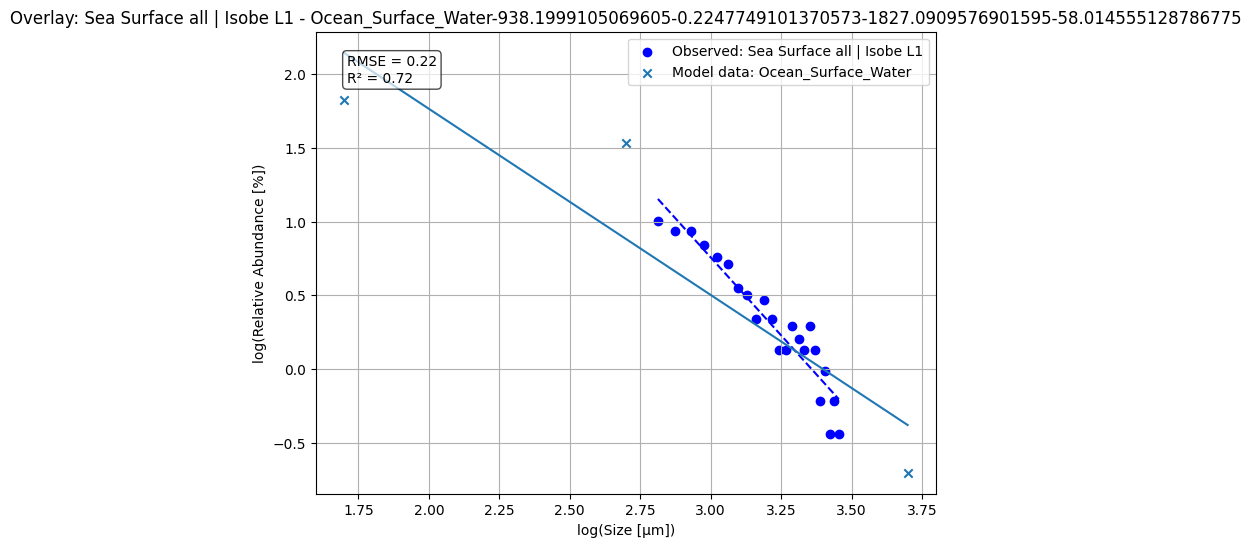

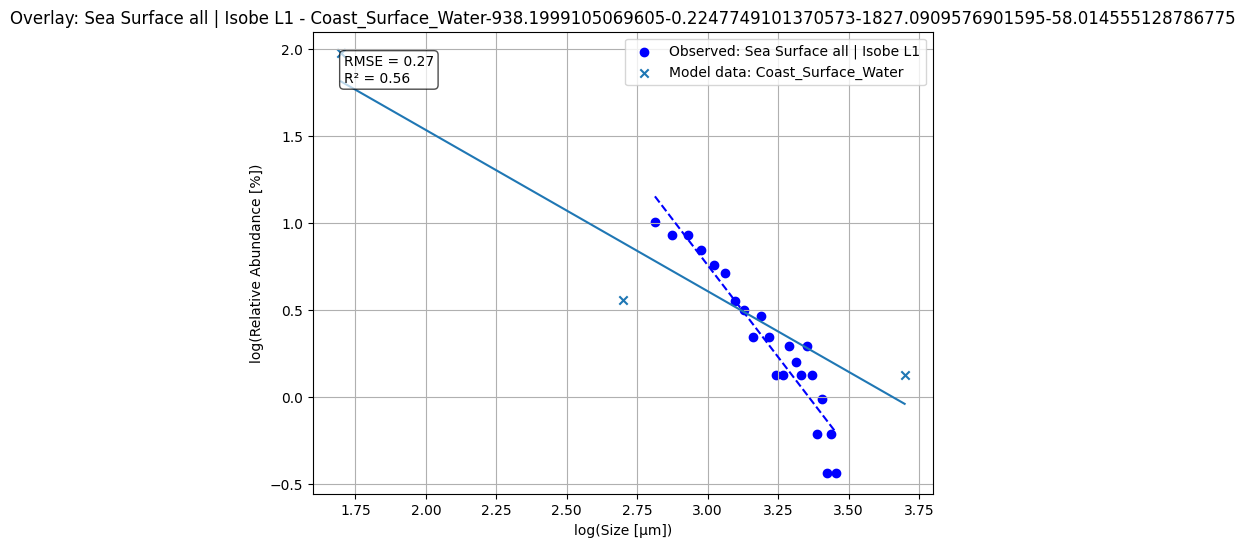

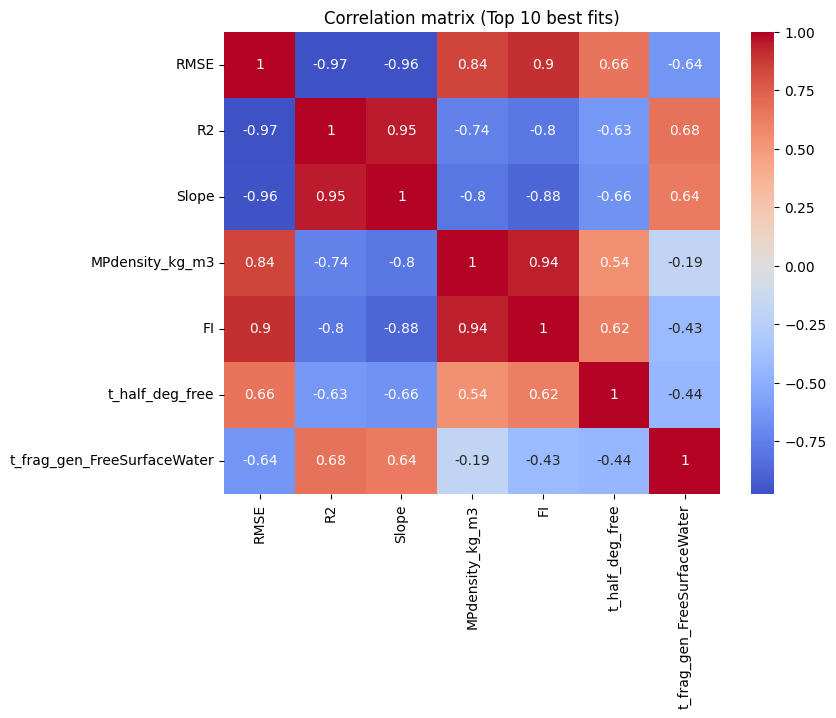

Running Monte Carlo analysis for article: Sea Surface all | Isobe L2
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done


Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 38782.28 cases/s]

Simulation complete! Runtime: 0:00:42.911344
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<?, ? cases/s]

Simulation complete! Runtime: 0:00:42.021558
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<?, ? cases/s]

Simulation complete! Runtime: 0:00:42.024988
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 14368.98 cases/s]

Simulation complete! Runtime: 0:00:42.546001


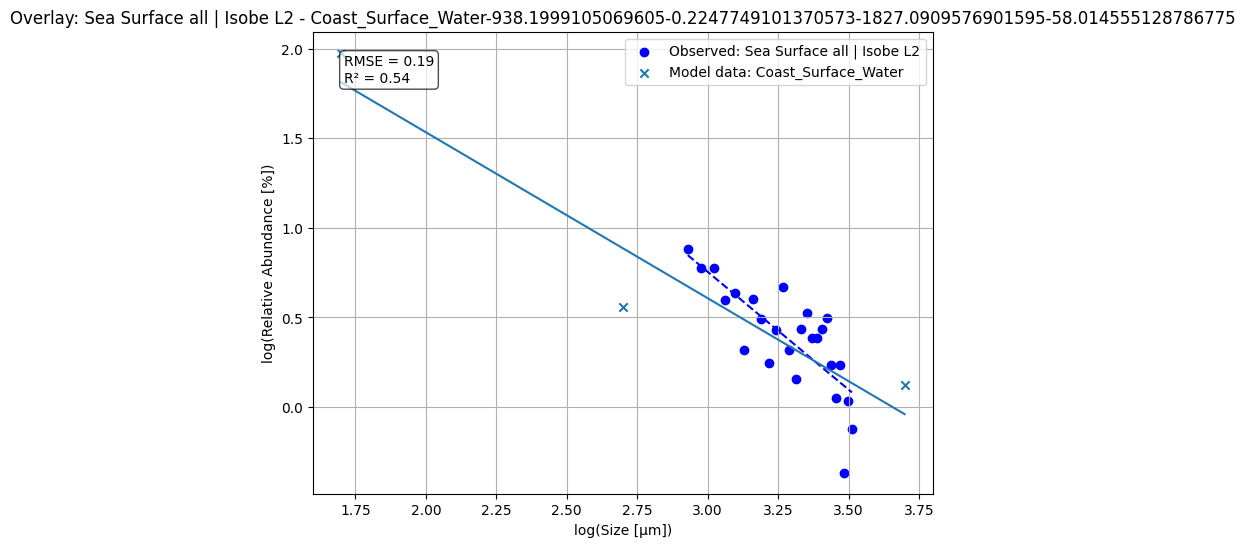

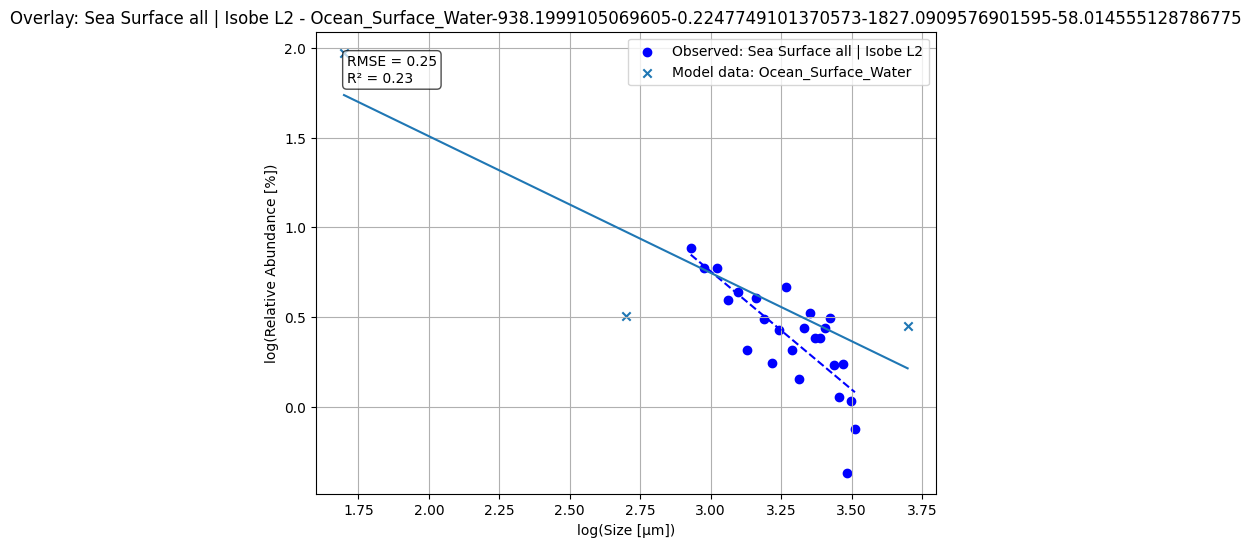

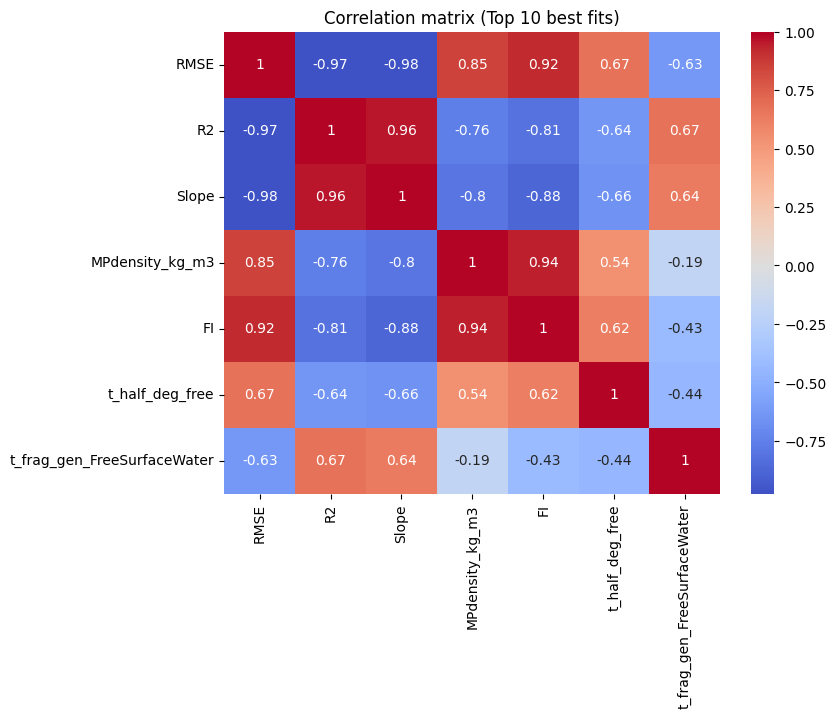

Running Monte Carlo analysis for article: Sea Surface all | Isobe L3
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done


Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 7017.99 cases/s]

Simulation complete! Runtime: 0:00:42.389729
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<?, ? cases/s]

Simulation complete! Runtime: 0:00:44.464244
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 7453.89 cases/s]

Simulation complete! Runtime: 0:00:48.310350
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<?, ? cases/s]

Simulation complete! Runtime: 0:00:42.350773


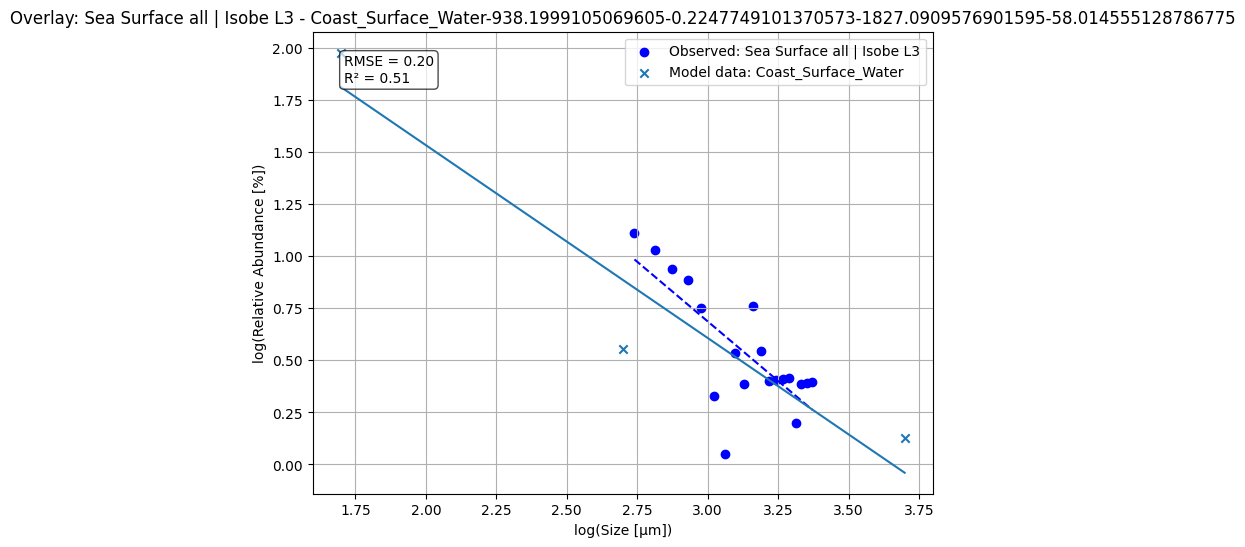

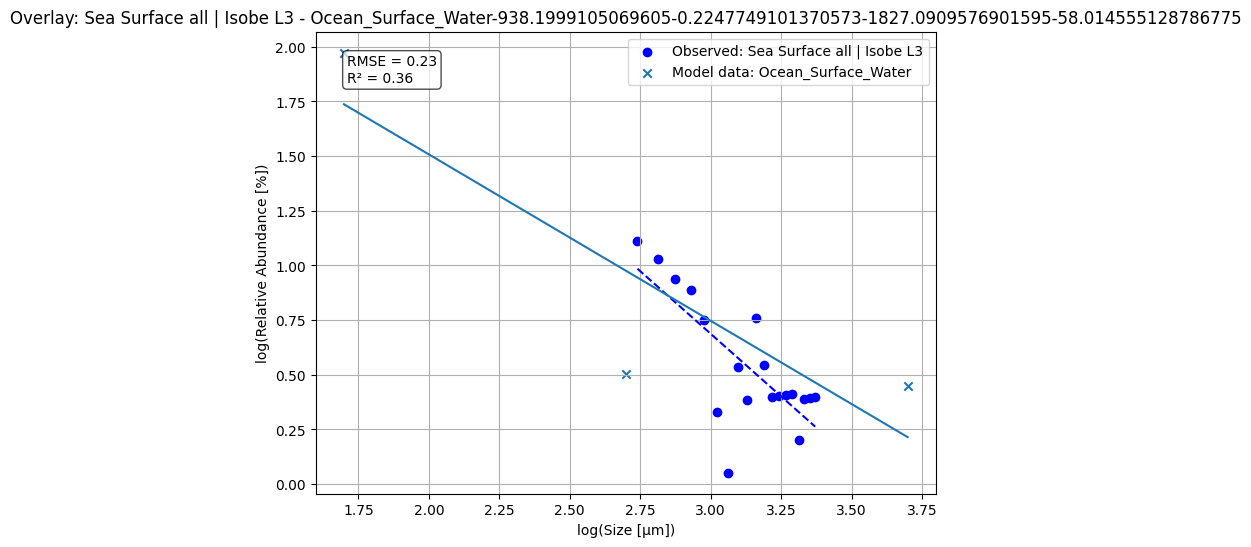

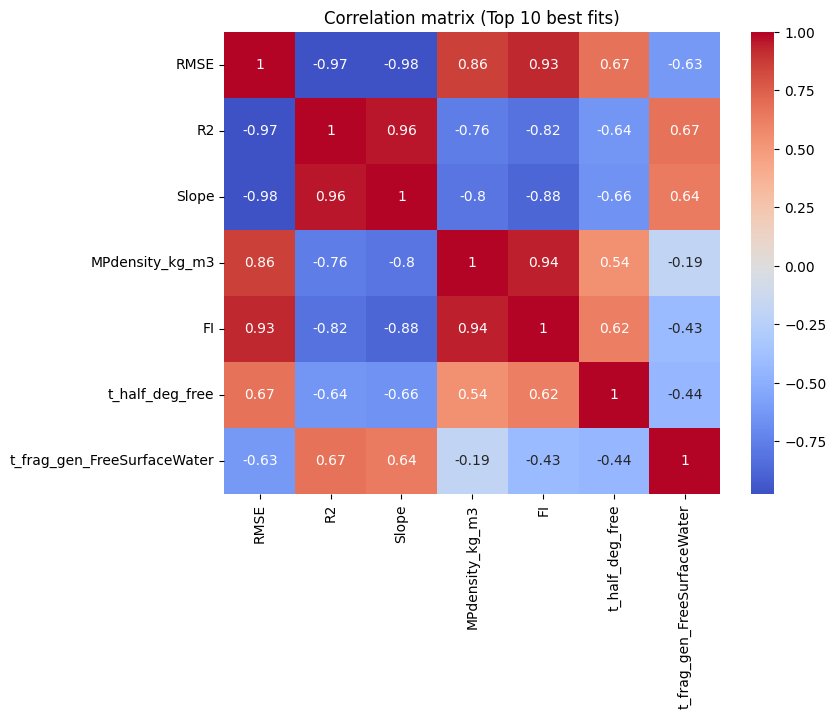

Running Monte Carlo analysis for article: Sea Surface all | Isobe L4
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done


Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 3398.95 cases/s]

Simulation complete! Runtime: 0:00:43.509179
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<?, ? cases/s]

Simulation complete! Runtime: 0:00:43.269532
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<?, ? cases/s]

Simulation complete! Runtime: 0:00:42.858549
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 5204.50 cases/s]

Simulation complete! Runtime: 0:00:41.907518


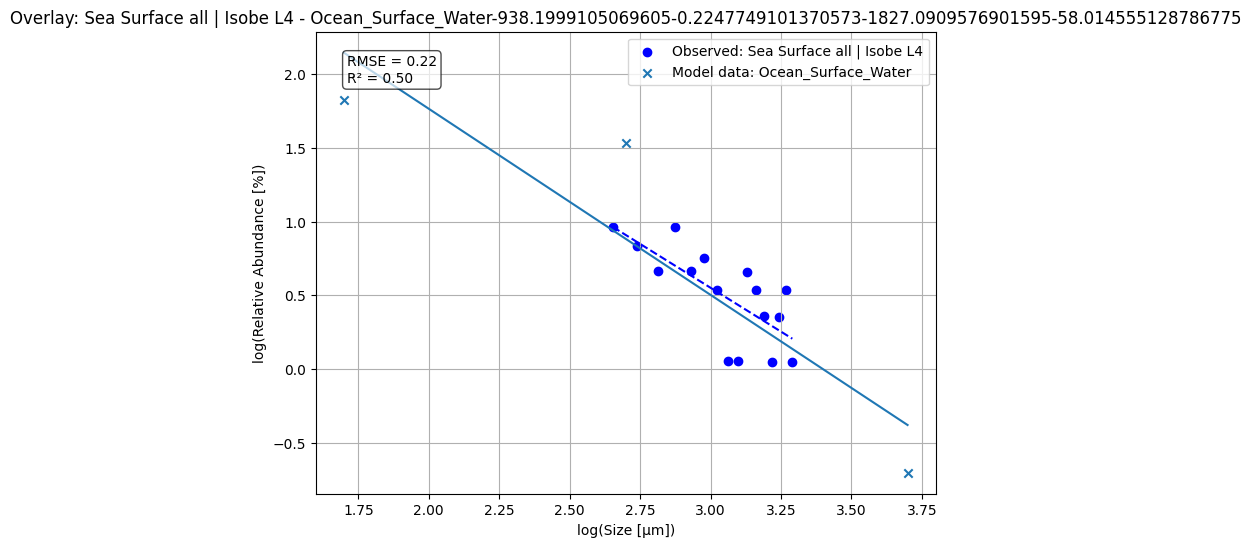

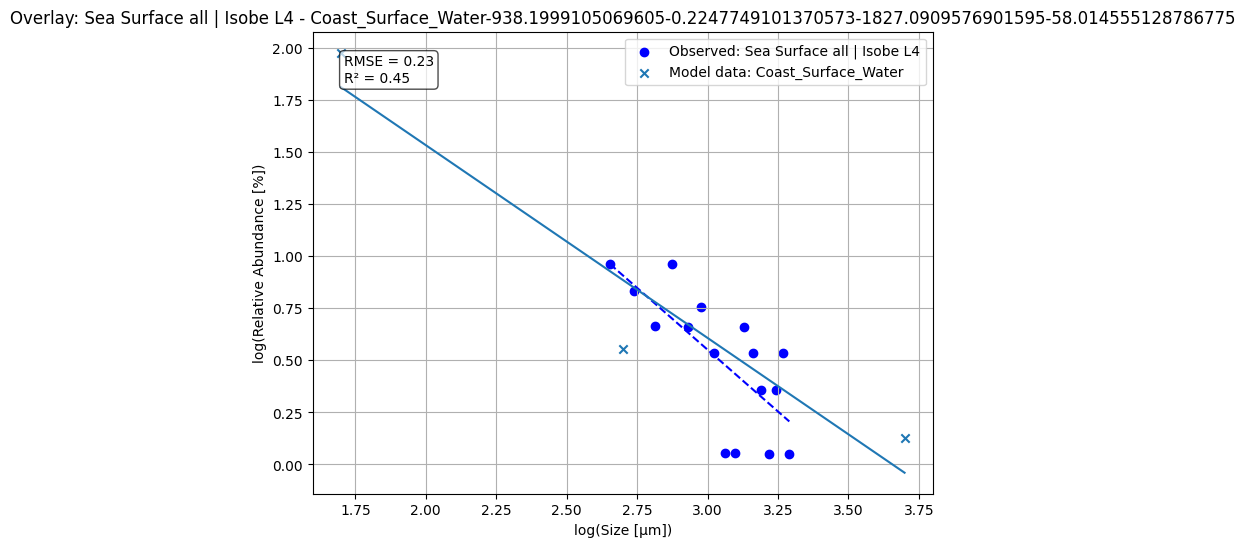

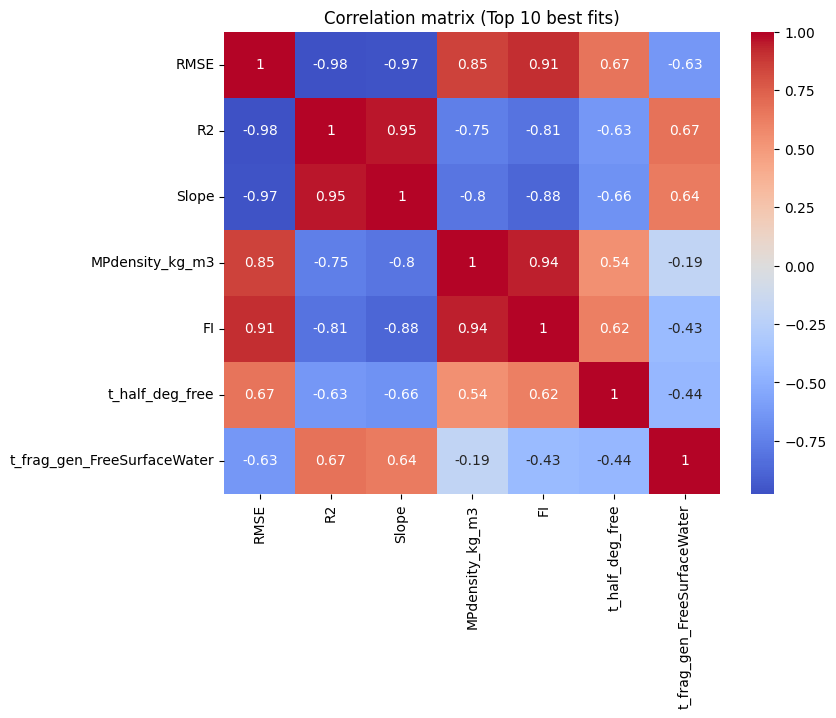

Running Monte Carlo analysis for article: FP all | Scheurer
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done


Postprocessing cases: 100%|██████████| 20/20 [00:00<?, ? cases/s]

Simulation complete! Runtime: 0:00:48.539551
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 1462.09 cases/s]

Simulation complete! Runtime: 0:00:45.067629


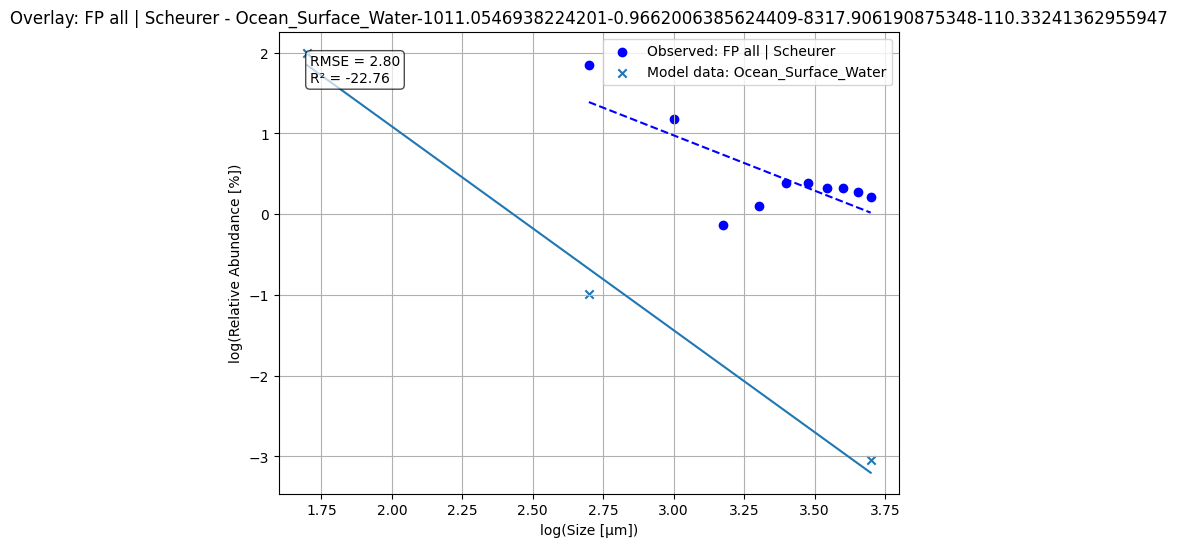

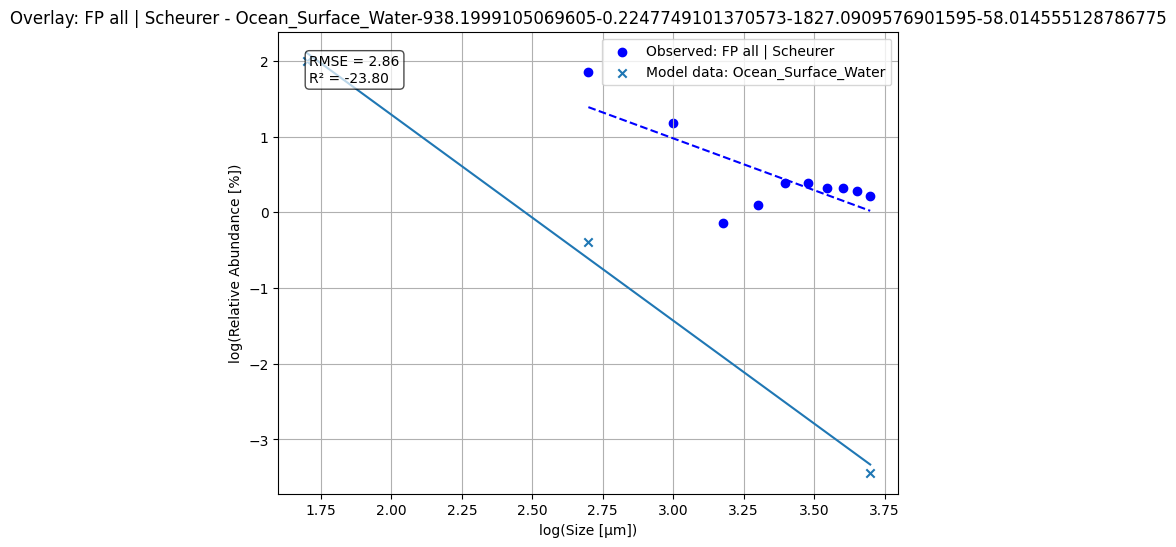

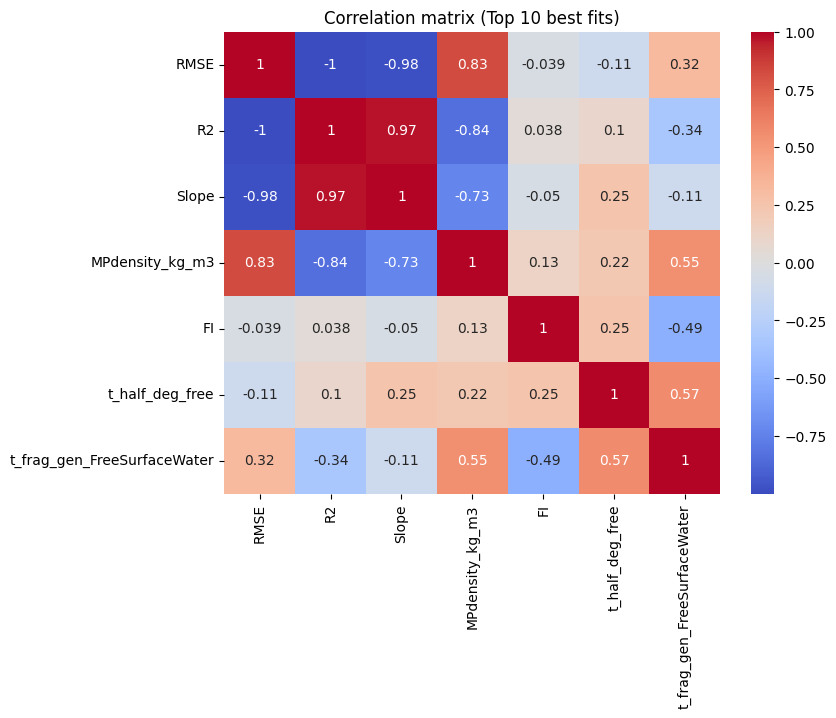

Running Monte Carlo analysis for article: Sea Surface Fragments | Song
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done


Postprocessing cases: 100%|██████████| 20/20 [00:00<?, ? cases/s]

Simulation complete! Runtime: 0:00:45.747912
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 8210.44 cases/s]

Simulation complete! Runtime: 0:00:50.216460
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 10010.27 cases/s]

Simulation complete! Runtime: 0:00:52.032302
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<?, ? cases/s]

Simulation complete! Runtime: 0:00:52.227940


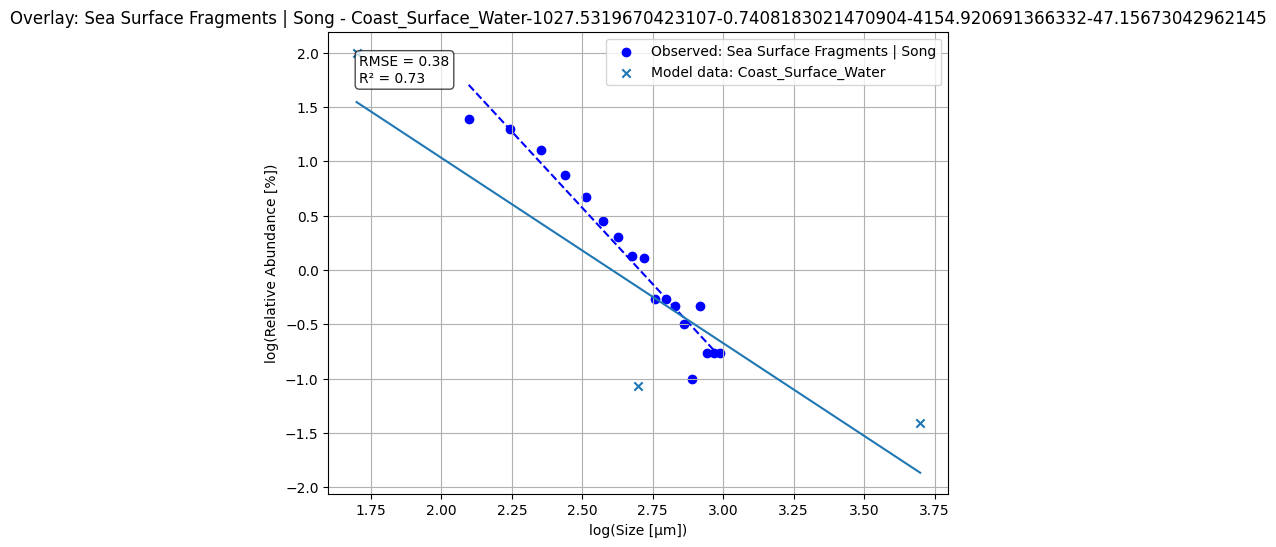

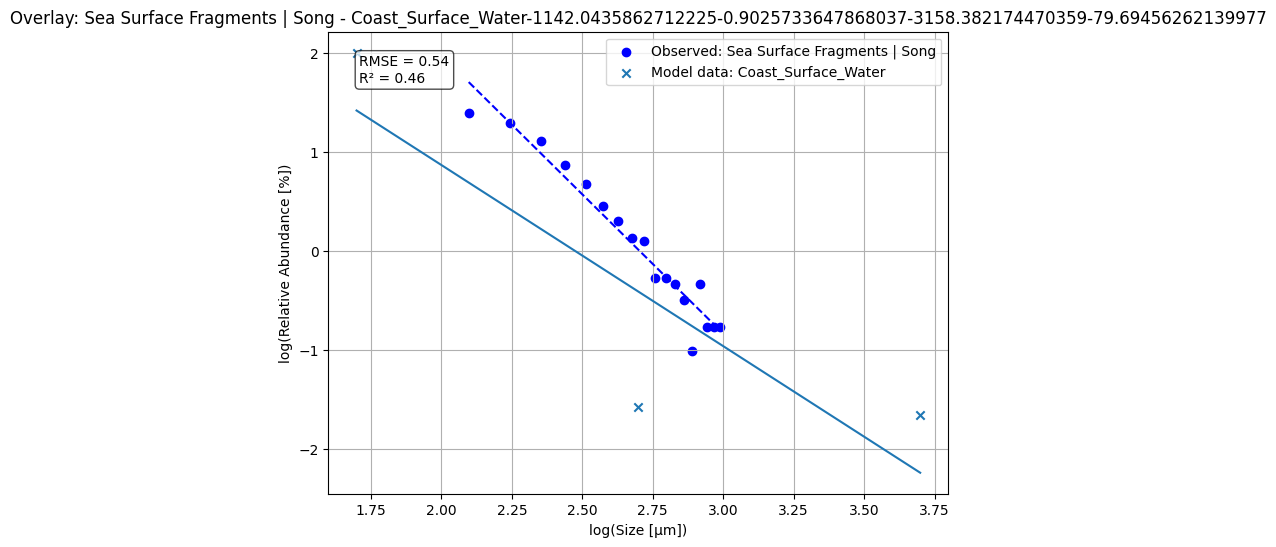

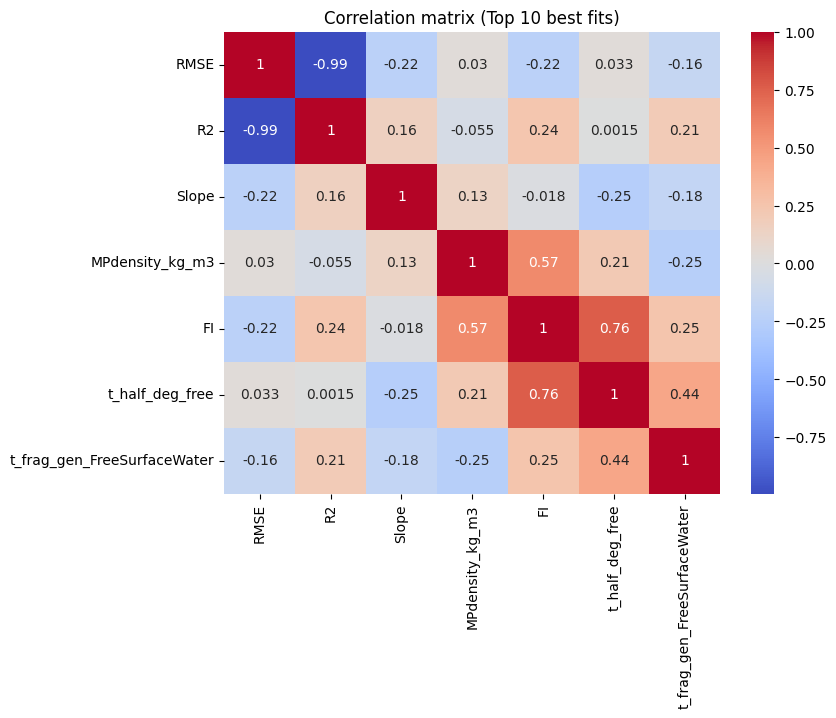

Running Monte Carlo analysis for article: Sea Surface Fibers | Song
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done


Postprocessing cases: 100%|██████████| 20/20 [00:00<?, ? cases/s]

Simulation complete! Runtime: 0:00:58.428468
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 10006.69 cases/s]

Simulation complete! Runtime: 0:00:48.742251
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 1239.12 cases/s]

Simulation complete! Runtime: 0:00:50.091667
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 2672.13 cases/s]

Simulation complete! Runtime: 0:00:50.485170


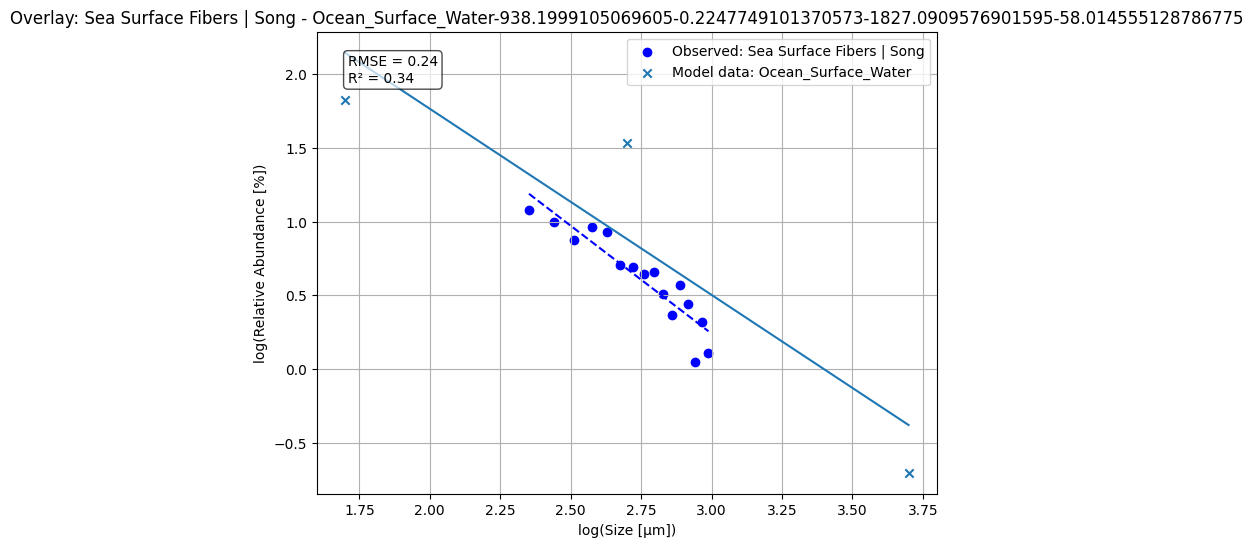

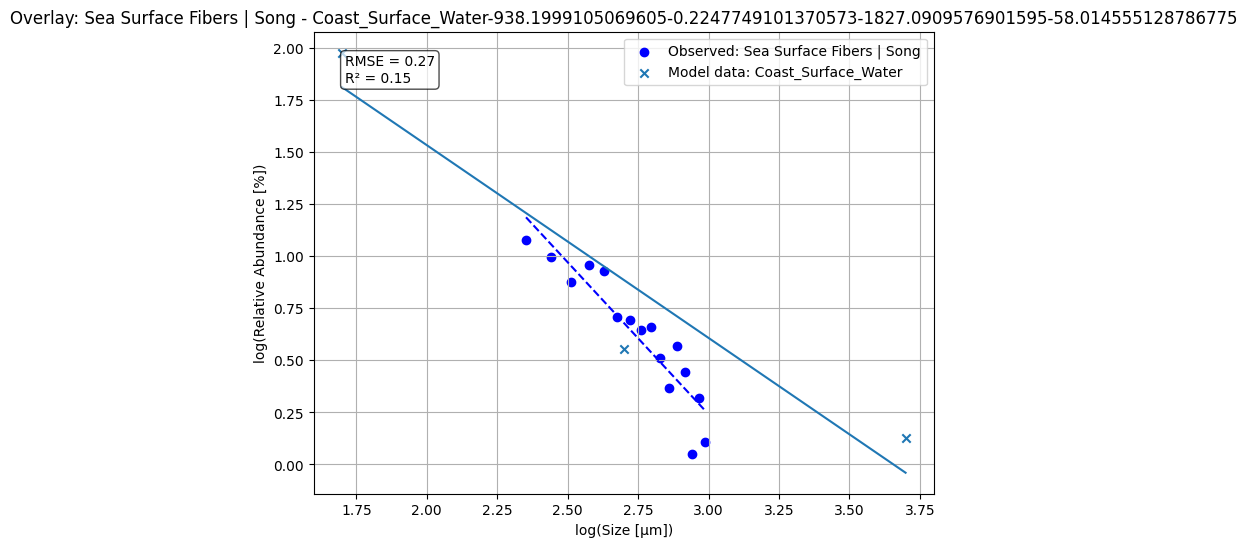

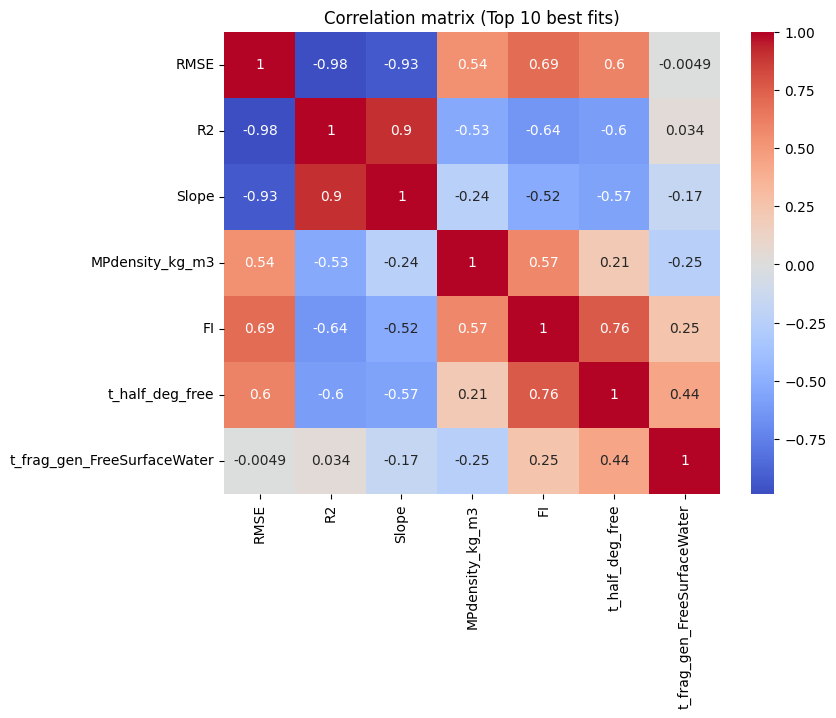

Running Monte Carlo analysis for article: Sea Surface all | Zhang
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done


Postprocessing cases: 100%|██████████| 20/20 [00:00<?, ? cases/s]

Simulation complete! Runtime: 0:00:49.770118
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 6992.25 cases/s]

Simulation complete! Runtime: 0:00:44.453200
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 6668.21 cases/s] 

Simulation complete! Runtime: 0:00:49.998996
Running 'UTOPIA_MC_simulation' Monte Carlo simulation with 20/20 cases...
Drawing random samples for 4 input variables via the 'sobol_random' method... Done
Generating cases... Done



Postprocessing cases: 100%|██████████| 20/20 [00:00<00:00, 9960.35 cases/s] 

Simulation complete! Runtime: 0:00:42.668847


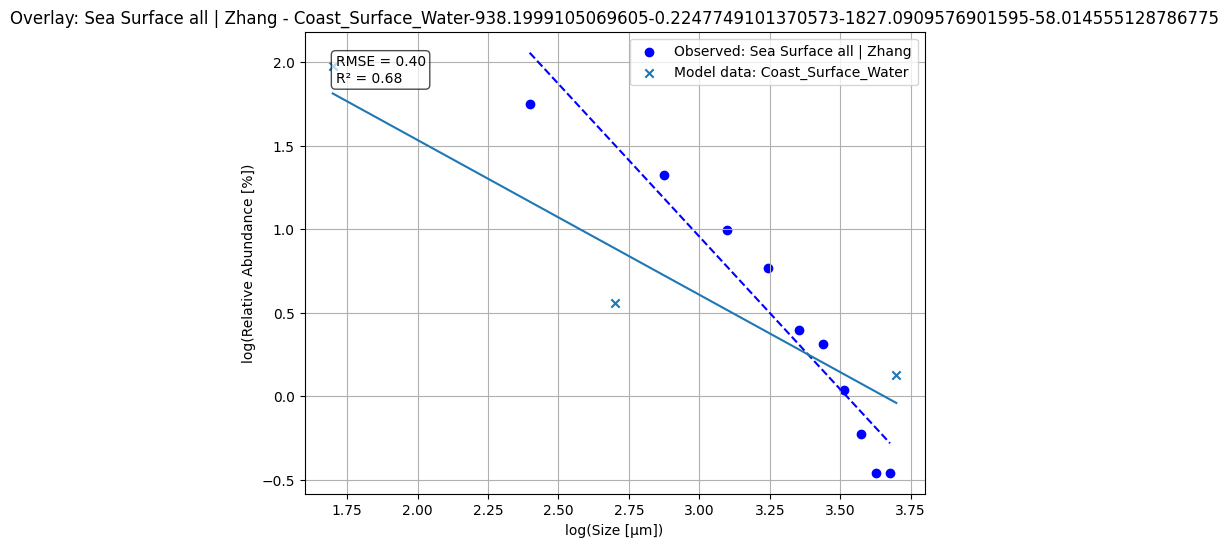

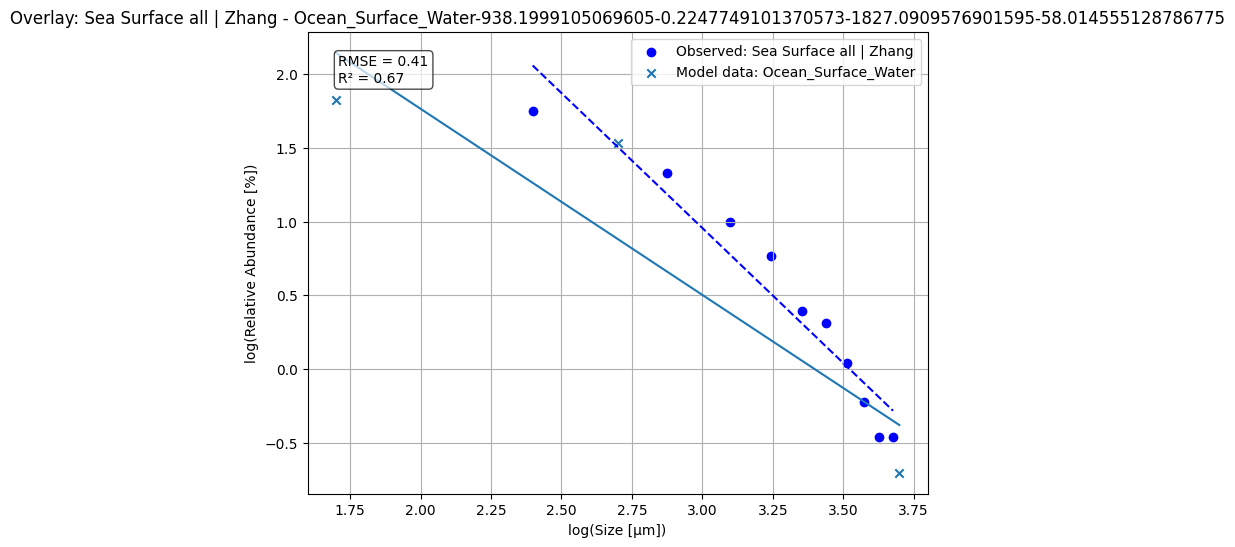

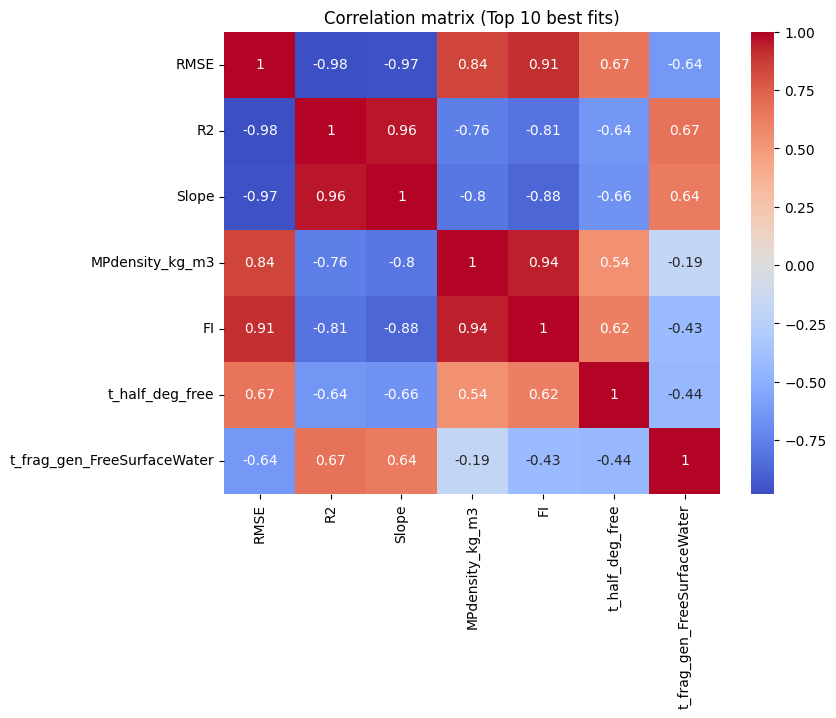

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from utopia.monte_carlo.montecarlo_analysis_paper import run_and_plot_top_results

MC_simulations_results_all={}
for art in overlay_emission_scenarios.keys():
    print(f"Running Monte Carlo analysis for article: {art}")
    MC_simulations_results=[]
    for comp in overlay_emission_scenarios[art]:
        # Set emissions to that compartment and include it in base_data file
        data_data["emiss_dict_g_s"]= set_emission(data_data["emiss_dict_g_s"].copy(), comp, "e", 100)
        
        
        #Run Monte Carlo analysis for each emission scenario and targer compartment
        for comp_T in overlay_compartments_mapping[art]:
            emission_comp=comp
            target_comp=comp_T
            sim= run_mc_analysis_paper(
            base_config=config_data,
            base_data=data_data,
            param_distributions=param_distributions,
            n_cases=20,art=art,emission_comp=emission_comp,target_comp=target_comp
        )
        
            # Convert sim results to dataframe
            df_MC_results = sim_to_dataframe(sim)
            
            
            MC_simulations_results.append(df_MC_results)
    MC_simulations_results = pd.concat(MC_simulations_results, ignore_index=True)
    input_params=["MPdensity_kg_m3", "FI", "t_half_deg_free", "t_frag_gen_FreeSurfaceWater"]
    tidy_mc_results=reshape_mc_results(MC_simulations_results, input_params, art)
    results_sorted_art = tidy_mc_results.sort_values("RMSE", ascending=True)
    # Keep e.g. top 20 best-fitting combinations
    top_results_art = results_sorted_art.head(20)
    run_and_plot_top_results(top_results_art[0:2],data_data, config_data)
    

    # Correlation heatmap for the top results
    corr = top_results_art[0:10][["RMSE", "R2", "Slope", "MPdensity_kg_m3", "FI", "t_half_deg_free", "t_frag_gen_FreeSurfaceWater"]].corr()

    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
    plt.title("Correlation matrix (Top 10 best fits)")
    plt.show()
    
    
    MC_simulations_results_all[art]=top_results_art
    
    
        

In [14]:
combined_df = pd.concat(MC_simulations_results_all.values(), ignore_index=True)

In [20]:
combined_df

Case         Observed_dataset Emission_Compartment   Target_Compartment  \
0     108  Sea Sediment | Bergmann   Coast_Column_Water       Sediment_Ocean   
1      68  Sea Sediment | Bergmann  Coast_Surface_Water       Sediment_Ocean   
2     100  Sea Sediment | Bergmann   Coast_Column_Water       Sediment_Ocean   
3     112  Sea Sediment | Bergmann   Coast_Column_Water       Sediment_Ocean   
4      72  Sea Sediment | Bergmann  Coast_Surface_Water       Sediment_Ocean   
..    ...                      ...                  ...                  ...   
355    61  Sea Surface all | Zhang   Surface_Freshwater  Ocean_Surface_Water   
356    47  Sea Surface all | Zhang   Surface_Freshwater  Coast_Surface_Water   
357    23  Sea Surface all | Zhang  Coast_Surface_Water  Ocean_Surface_Water   
358    63  Sea Surface all | Zhang   Surface_Freshwater  Ocean_Surface_Water   
359    37  Sea Surface all | Zhang  Coast_Surface_Water  Ocean_Surface_Water   

         RMSE         R2     Slope  Spearman_r  Pass_Spearman  \
0    0.306841  -0.542379 -2.655127        -1.0           True   
1    0.314419  -0.619506 -2.627525        -1.0           True   
2    0.319249  -0.669642 -2.453298        -1.0           True   
3    0.336169  -0.851313 -2.519515        -1.0           True   
4    0.342700  -0.923945 -2.492947        -1.0           True   
..        ...        ...       ...         ...            ...   
355  3.210394 -19.030002 -2.794831        -1.0           True   
356  3.554319 -23.551460 -2.733908        -1.0           True   
357  4.112485 -31.867982 -3.125205        -1.0           True   
358  4.395308 -36.544219 -3.319479        -1.0           True   
359  4.651851 -41.054845 -3.557464        -1.0           True   

     MPdensity_kg_m3        FI  t_half_deg_free  t_frag_gen_FreeSurfaceWater  
0        1334.859380  0.269348      2665.785177                    31.280483  
1        1334.859380  0.269348      2665.785177                    31.280483  
2        1223.294660  0.054891      6510.335737                    18.298327  
3        1170.689441  0.163532     10975.160488                    41.971349  
4        1170.689441  0.163532     10975.160488                    41.971349  
..               ...       ...              ...                          ...  
355      1027.531967  0.740818      4154.920691                    47.156730  
356      1302.585757  0.539578      9481.499850                    12.343862  
357      1142.043586  0.902573      3158.382174                    79.694563  
358      1142.043586  0.902573      3158.382174                    79.694563  
359      1052.671922  0.811533      3073.415520                    14.554329  

[360 rows x 13 columns]

Top 20 best fitting results for each observed dataset

In [33]:
combined_results_shorted=combined_df.sort_values("RMSE", ascending=True)
combined_results_shorted

Case            Observed_dataset   Emission_Compartment  \
120   149  Fragments in sediment | Eo     Surface_Freshwater   
220     6  Sea Surface all | Isobe L2     Surface_Freshwater   
240     6  Sea Surface all | Isobe L3     Surface_Freshwater   
121   137  Fragments in sediment | Eo     Surface_Freshwater   
122   125  Fragments in sediment | Eo     Surface_Freshwater   
..    ...                         ...                    ...   
295    34           FP all | Scheurer  Impacted_Soil_Surface   
296    32           FP all | Scheurer  Impacted_Soil_Surface   
297    35           FP all | Scheurer  Impacted_Soil_Surface   
298     4           FP all | Scheurer  Impacted_Soil_Surface   
299    15           FP all | Scheurer  Impacted_Soil_Surface   

      Target_Compartment      RMSE          R2     Slope  Spearman_r  \
120    Beaches_Deep_Soil  0.187272    0.865844 -1.988877        -1.0   
220  Coast_Surface_Water  0.192740    0.540131 -0.926349        -1.0   
240  Coast_Surface_Water  0.196303    0.512105 -0.926349        -1.0   
121       Sediment_Coast  0.210465    0.830557 -1.757989        -1.0   
122       Sediment_Coast  0.219214    0.816177 -1.605927        -1.0   
..                   ...       ...         ...       ...         ...   
295  Ocean_Surface_Water  6.005672 -108.220248 -4.254892        -1.0   
296  Ocean_Surface_Water  6.011729 -108.440677 -4.225925        -1.0   
297  Ocean_Surface_Water  6.018758 -108.696750 -4.448283        -1.0   
298  Coast_Surface_Water  6.061087 -110.245151 -4.185854        -1.0   
299  Coast_Surface_Water  6.093963 -111.455234 -4.489052        -1.0   

     Pass_Spearman  MPdensity_kg_m3        FI  t_half_deg_free  \
120           True      1011.054694  0.966201      8317.906191   
220           True       938.199911  0.224775      1827.090958   
240           True       938.199911  0.224775      1827.090958   
121           True      1052.671922  0.811533      3073.415520   
122           True      1067.147583  0.814583      7649.971822   
..             ...              ...       ...              ...   
295           True      1038.834733  0.450996      5968.470983   
296           True      1170.689441  0.163532     10975.160488   
297           True      1266.860208  0.753409      4509.321025   
298           True      1183.945885  0.387262      4865.625691   
299           True      1266.860208  0.753409      4509.321025   

     t_frag_gen_FreeSurfaceWater  
120                   110.332414  
220                    58.014555  
240                    58.014555  
121                    14.554329  
122                    27.484251  
..                           ...  
295                    99.035129  
296                    41.971349  
297                    33.637734  
298                   162.674424  
299                    33.637734  

[360 rows x 13 columns]

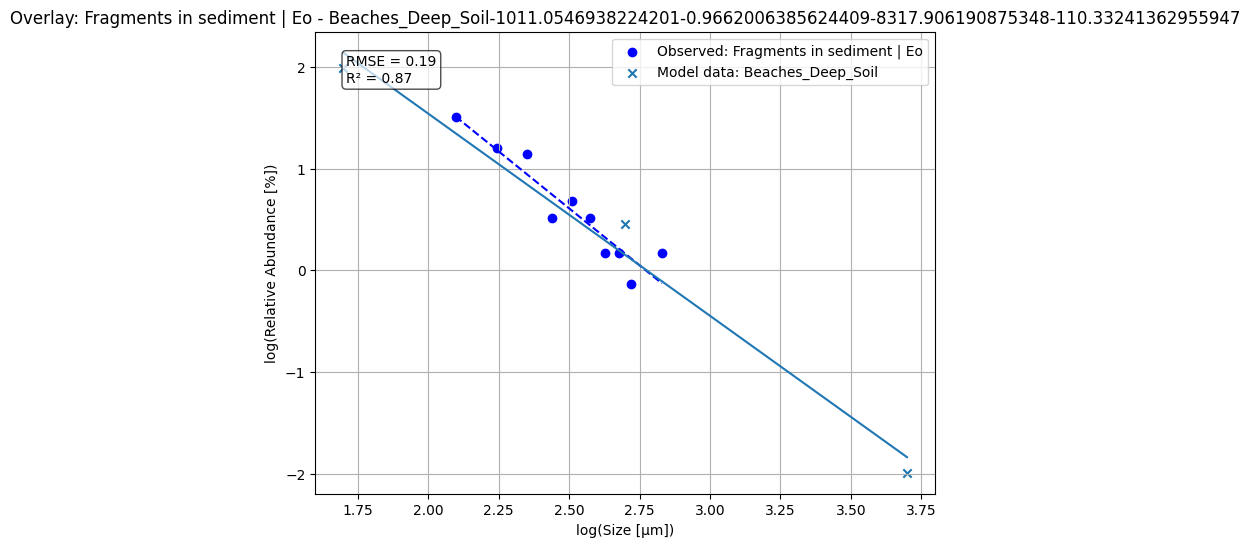

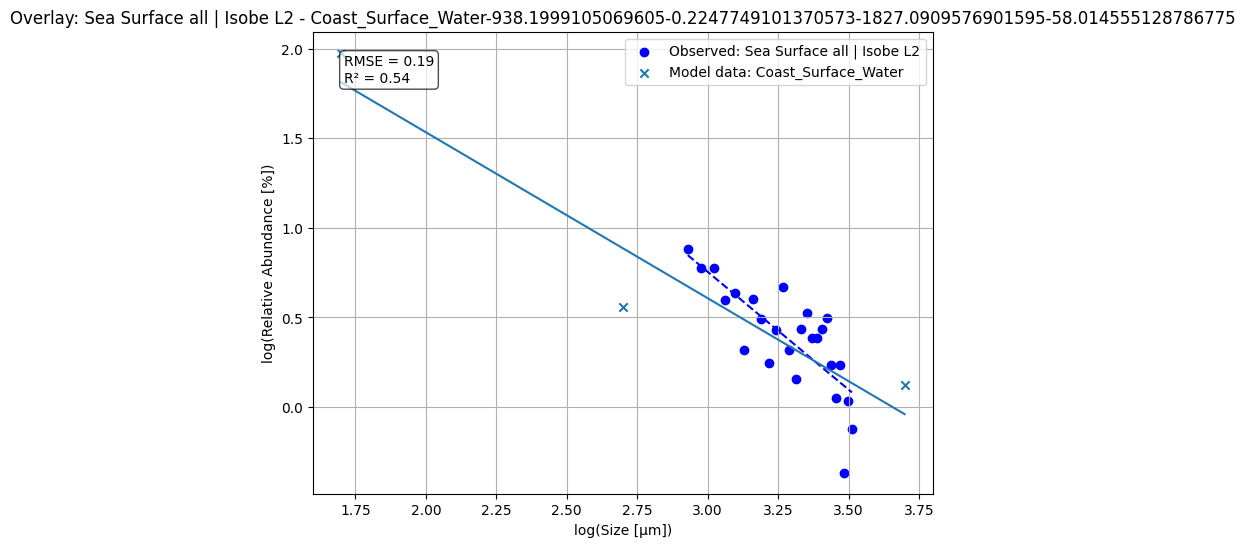

In [34]:

from utopia.monte_carlo.montecarlo_analysis_paper import run_and_plot_top_results
run_and_plot_top_results(combined_results_shorted[0:2],data_data, config_data)

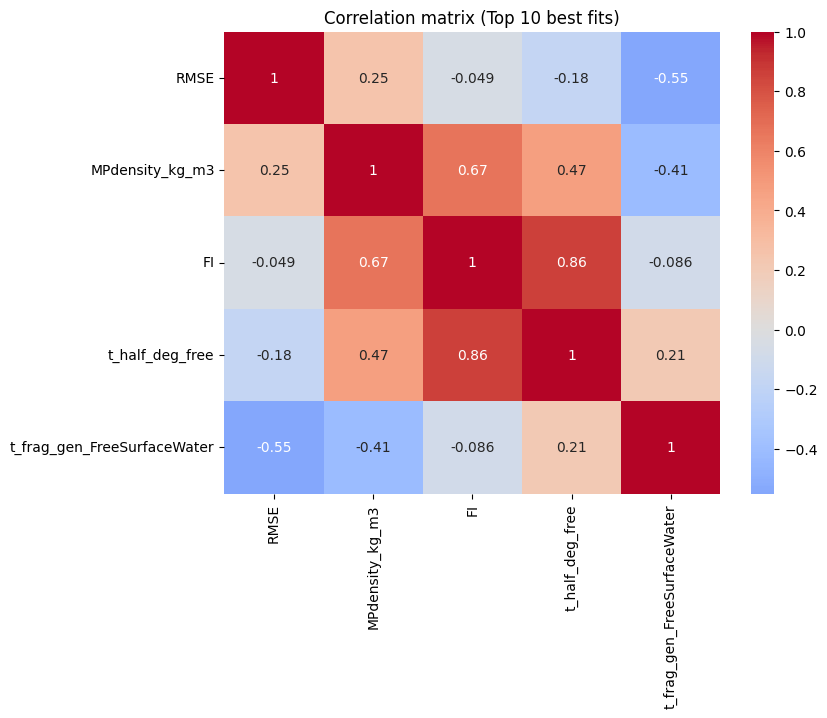

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation heatmap for the top results
corr = combined_results_shorted[0:10][["RMSE", "MPdensity_kg_m3", "FI", "t_half_deg_free", "t_frag_gen_FreeSurfaceWater"]].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation matrix (Top 10 best fits)")
plt.show()

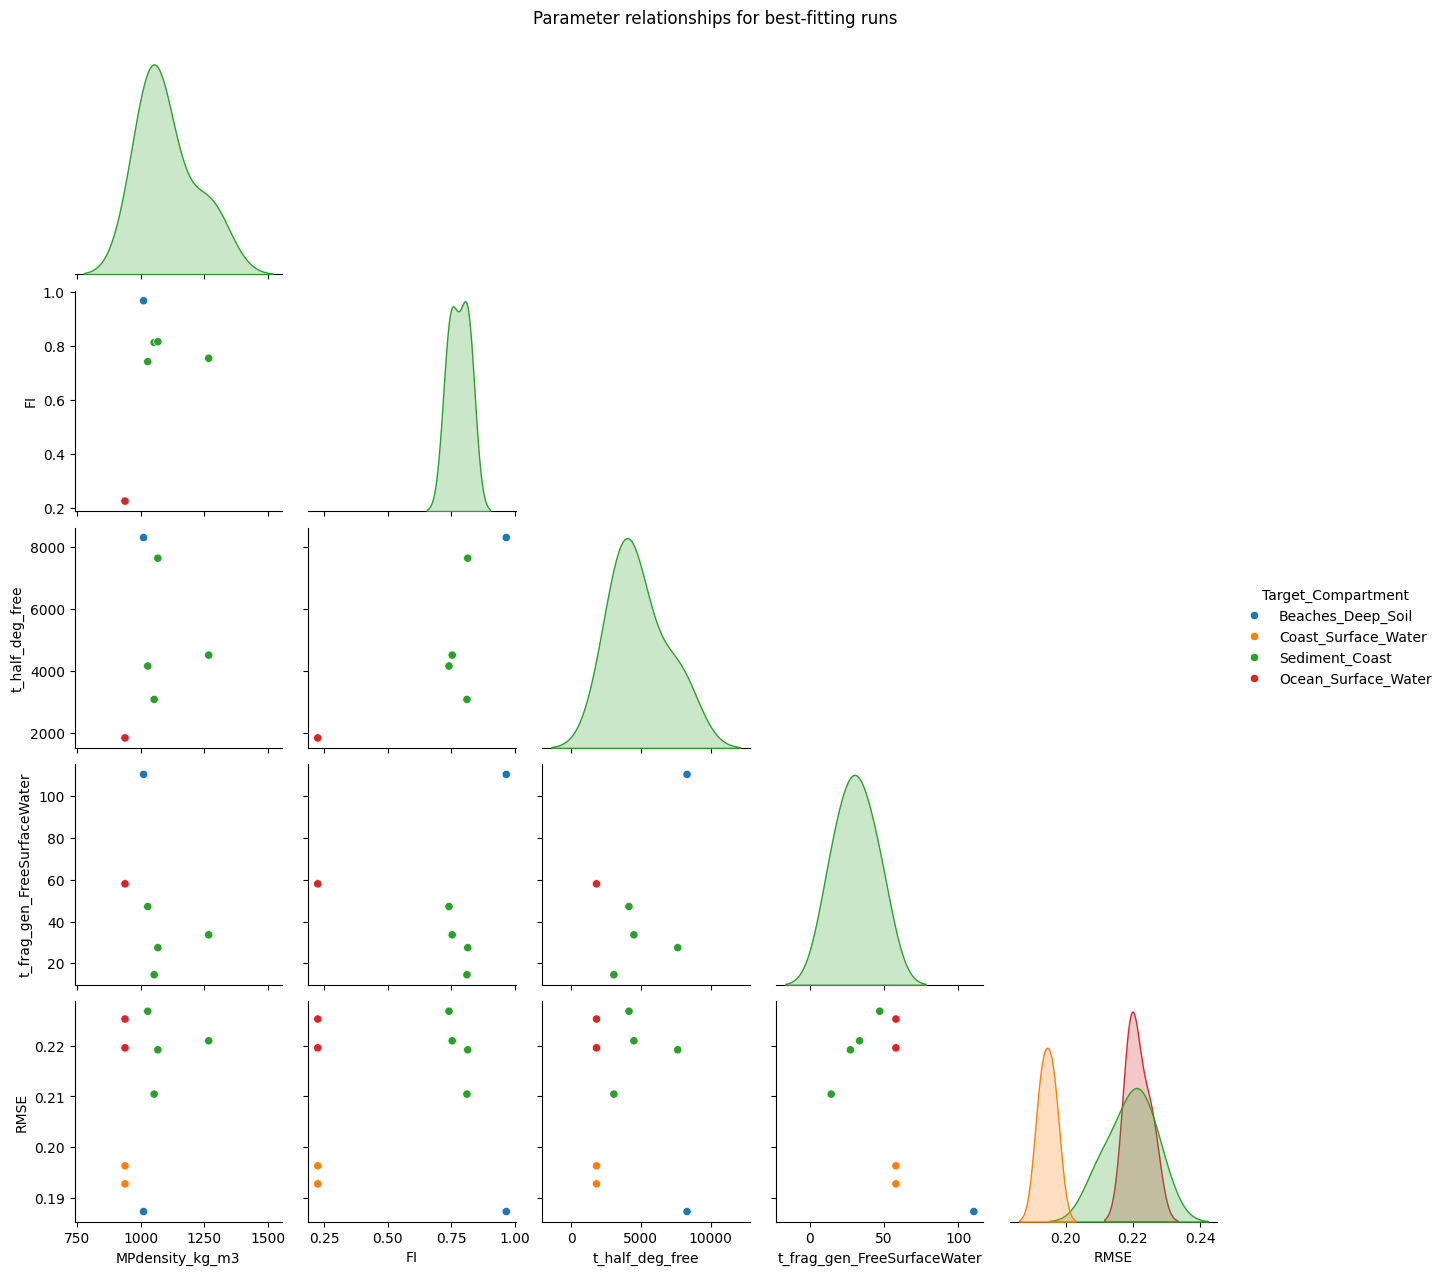

In [46]:
# Pair-wise relationships for the top results
sns.pairplot(
    combined_results_shorted[0:10],
    vars=["MPdensity_kg_m3", "FI", "t_half_deg_free", "t_frag_gen_FreeSurfaceWater","RMSE"],
    hue="Target_Compartment",
    corner=True
)
plt.suptitle("Parameter relationships for best-fitting runs", y=1.02)
plt.show()

In [28]:
# Read data from CSV if needed
combined_results = pd.read_csv("loop_all.csv")
df=combined_results.copy()

In [29]:
combined_results_shorted=df.sort_values("RMSE", ascending=True)

In [30]:
combined_results_shorted[1:20]

Case            Observed_dataset Emission_Compartment  \
220     6  Sea Surface all | Isobe L2   Surface_Freshwater   
240     6  Sea Surface all | Isobe L3   Surface_Freshwater   
121   137  Fragments in sediment | Eo   Surface_Freshwater   
122   125  Fragments in sediment | Eo   Surface_Freshwater   
260    26  Sea Surface all | Isobe L4   Surface_Freshwater   
200    26  Sea Surface all | Isobe L1   Surface_Freshwater   
123   135  Fragments in sediment | Eo   Surface_Freshwater   
241    66  Sea Surface all | Isobe L3  Coast_Surface_Water   
124   121  Fragments in sediment | Eo   Surface_Freshwater   
261     6  Sea Surface all | Isobe L4   Surface_Freshwater   
125   131  Fragments in sediment | Eo   Surface_Freshwater   
20     41       Sea Surface all | Cai  Coast_Surface_Water   
320    66   Sea Surface Fibers | Song   Surface_Freshwater   
140   123     Fibers in sediment | Eo   Surface_Freshwater   
221    66  Sea Surface all | Isobe L2  Coast_Surface_Water   
242    26  Sea Surface all | Isobe L3   Surface_Freshwater   
201     6  Sea Surface all | Isobe L1   Surface_Freshwater   
321    46   Sea Surface Fibers | Song   Surface_Freshwater   
80     46     Fragments in water | Eo   Surface_Freshwater   

      Target_Compartment      RMSE        R2     Slope  Spearman_r  \
220  Coast_Surface_Water  0.192740  0.540131 -0.926349        -1.0   
240  Coast_Surface_Water  0.196303  0.512105 -0.926349        -1.0   
121       Sediment_Coast  0.210465  0.830557 -1.757989        -1.0   
122       Sediment_Coast  0.219214  0.816177 -1.605927        -1.0   
260  Ocean_Surface_Water  0.219473  0.496743 -1.260351        -1.0   
200  Ocean_Surface_Water  0.219608  0.717863 -1.260351        -1.0   
123       Sediment_Coast  0.220993  0.813182 -1.619336        -1.0   
241  Ocean_Surface_Water  0.225292  0.357365 -0.761238        -1.0   
124       Sediment_Coast  0.226836  0.803171 -1.555892        -1.0   
261  Coast_Surface_Water  0.228836  0.452885 -0.926349        -1.0   
125       Sediment_Coast  0.240624  0.778517 -1.524742        -1.0   
20   Coast_Surface_Water  0.241146  0.833343 -1.488332        -1.0   
320  Ocean_Surface_Water  0.242450  0.341708 -1.260351        -1.0   
140       Sediment_Coast  0.246943 -0.238814 -1.236710        -1.0   
221  Ocean_Surface_Water  0.248879  0.233221 -0.761238        -1.0   
242  Ocean_Surface_Water  0.272301  0.061204 -1.260351        -1.0   
201  Coast_Surface_Water  0.273270  0.563134 -0.926349        -1.0   
321  Coast_Surface_Water  0.274691  0.154986 -0.926349        -1.0   
80       Bulk_Freshwater  0.280510  0.837037 -1.644561        -1.0   

     Pass_Spearman  MPdensity_kg_m3        FI  t_half_deg_free  \
220           True       938.199911  0.224775      1827.090958   
240           True       938.199911  0.224775      1827.090958   
121           True      1052.671922  0.811533      3073.415520   
122           True      1067.147583  0.814583      7649.971822   
260           True       938.199911  0.224775      1827.090958   
200           True       938.199911  0.224775      1827.090958   
123           True      1266.860208  0.753409      4509.321025   
241           True       938.199911  0.224775      1827.090958   
124           True      1027.531967  0.740818      4154.920691   
261           True       938.199911  0.224775      1827.090958   
125           True      1193.888212  0.679468      7014.614289   
20            True      1027.531967  0.740818      4154.920691   
320           True       938.199911  0.224775      1827.090958   
140           True      1142.043586  0.902573      3158.382174   
221           True       938.199911  0.224775      1827.090958   
242           True       938.199911  0.224775      1827.090958   
201           True       938.199911  0.224775      1827.090958   
321           True       938.199911  0.224775      1827.090958   
80            True       938.199911  0.224775      1827.090958   

     t_frag_gen_FreeSurfaceWater  
220    

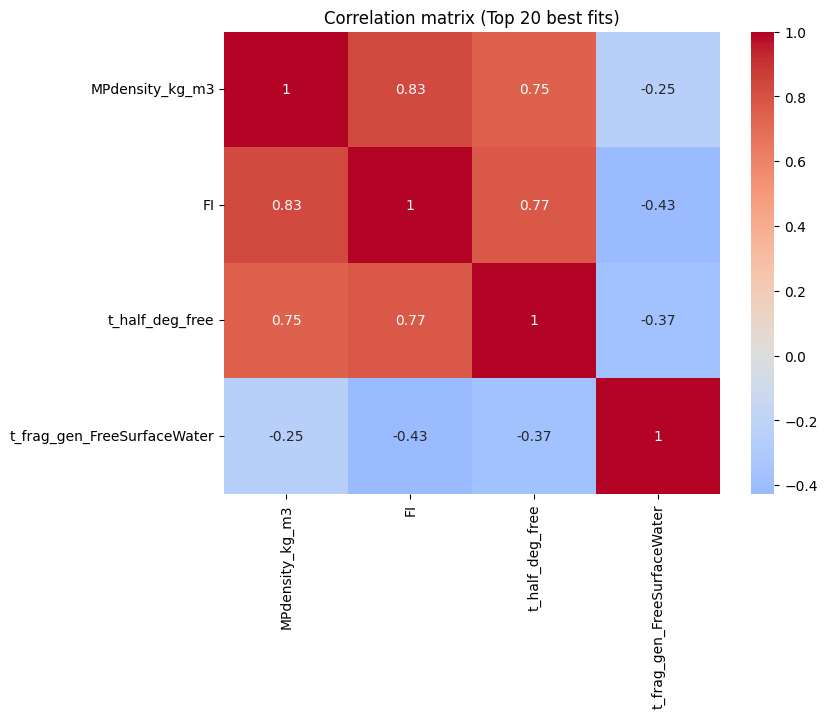

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation heatmap for the top results
corr = combined_results_shorted[1:20][["MPdensity_kg_m3", "FI", "t_half_deg_free", "t_frag_gen_FreeSurfaceWater"]].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation matrix (Top 20 best fits)")
plt.show()

In [ ]:
# Write up conclusions and next steps

# Best fits corresponds to 2 archetypical types of plastic:
# 1. Low density plastic (LDP) provides best fits to the monitoring data when framgentation index is low (more erosive fragmentation) and and disintegration half-life is short. Fragmentation timescale seems to not play a significant role according to the correlation matrix.
# 2. High density plastic (HDP), provides best fits when fragmentation index is high (more explosive fragmentation) and disintegration half-life is long. Fragmentation timescale seems to not play a significant role according to the correlation matrix.

# We will run scenarios for the two archetipycal plastics and compare results to the articles data to plot best fits against observed data.

In [32]:
# Set up scenario simulation for LDP and HDP
from utopia.utopia import utopiaModel
# Load the default configuration and data from the 'data' folder.
data_data = utopiaModel.load_json_file("data/default_data.json")
config_data = utopiaModel.load_json_file("data/default_config.json")
# Display the loaded config and data to ensure they were loaded correctly.
print("Loaded Configuration Data:", config_data)
print("Loaded Input Data:", data_data)


Loaded Configuration Data: {'big_bin_diameter_um': 5000, 'N_sizeBins': 5, 'vol_algal_cell_m3': 2e-16, 'spm_density_kg_m3': 1388, 'boxName': 'Utopia', 'comp_input_file_name': 'inputs_compartments.csv', 'comp_interactFile_name': 'compartment_interactions.csv', 'MPforms_list': ['freeMP', 'heterMP', 'biofMP', 'heterBiofMP'], 'solver': 'SteadyState', 'compartment_types': {'UTOPIA_surfaceSea_water_compartments': ['Ocean_Surface_Water', 'Coast_Surface_Water'], 'UTOPIA_water_compartments': ['Ocean_Mixed_Water', 'Ocean_Column_Water', 'Coast_Column_Water', 'Surface_Freshwater', 'Bulk_Freshwater'], 'UTOPIA_deep_soil_compartments': ['Beaches_Deep_Soil', 'Background_Soil', 'Impacted_Soil'], 'UTOPIA_soil_surface_compartments': ['Beaches_Soil_Surface', 'Background_Soil_Surface', 'Impacted_Soil_Surface'], 'UTOPIA_sediment_compartment': ['Sediment_Freshwater', 'Sediment_Ocean', 'Sediment_Coast'], 'UTOPIA_air_compartments': ['Air']}}
Loaded Input Data: {'MPdensity_kg_m3': 980, 'MP_composition': 'PE', 's

In [ ]:

# Define modifications (follow the structure providede in the default configuration data (data_data))
modifications = {
    "MPdensity_kg_m3": 900,
    "MP_composition": "PE",
    'FI': 0.2,
    "t_half_deg_free": 3000,
    "t_frag_gen_FreeSurfaceWater": 32
}
# Modify and save the data
model.modify_and_save_data(data_data, modifications, "custom_data.json")



In [ ]:

LDP_simulations_results_all={}
for art in overlay_emission_scenarios.keys():
    print(f"Running Monte Carlo analysis for article: {art}")
    MC_simulations_results=[]
    for comp in overlay_emission_scenarios[art]:
        # Set emissions to that compartment and include it in base_data file
        data_data["emiss_dict_g_s"]= set_emission(data_data["emiss_dict_g_s"].copy(), comp, "e", 100)
        
        
        #Run Monte Carlo analysis for each emission scenario and targer compartment

Can we conclude from the correlation values that best fits (lowest RMSE) are associated to lowest densities and FI values?

In [10]:

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Suppose your dataframe is df
# Identify features and target
target = 'RMSE'
numeric_features = ['MPdensity_kg_m3', 'FI', 't_half_deg_free', 't_frag_gen_FreeSurfaceWater']
#categorical_features = ['Observed_dataset', 'Emission_Compartment', 'Target_Compartment']

#X = df[numeric_features + categorical_features]
X = df[numeric_features]
y = df[target]

# One-hot encode categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        #('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)


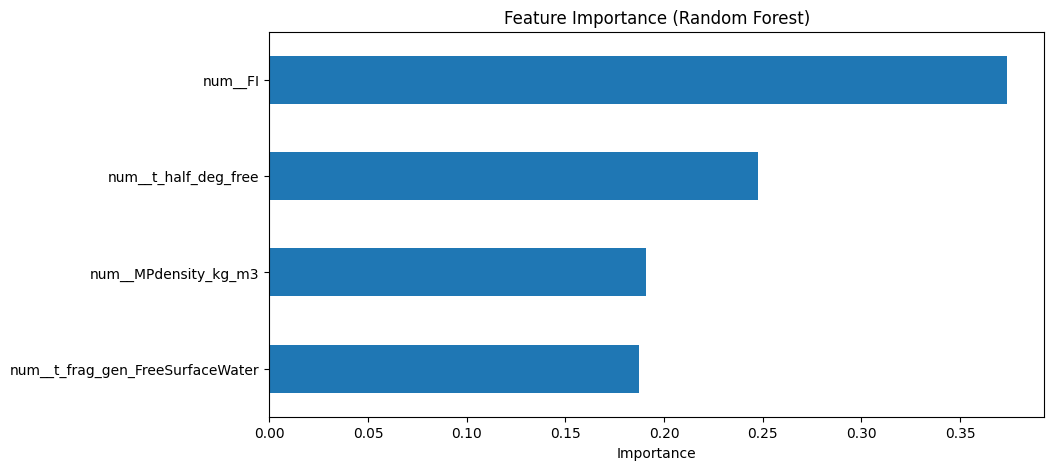

num__FI                             0.373965
num__t_half_deg_free                0.247732
num__MPdensity_kg_m3                0.190985
num__t_frag_gen_FreeSurfaceWater    0.187317
dtype: float64

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import pandas as pd

# Build pipeline
model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('rf', RandomForestRegressor(n_estimators=500, random_state=42))
])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit model
model.fit(X_train, y_train)

# Extract feature importances
rf = model.named_steps['rf']
feature_names = model.named_steps['preprocess'].get_feature_names_out()
importances = pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False)

# Plot importance
plt.figure(figsize=(10, 5))
importances[:15].plot(kind='barh')
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.show()

importances.head(10)
